In [1]:
import numpy as np
import glob
import pandas as pd
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv(r'C:\Users\u22u97\Desktop\NOx Prediction\Data shared folder\Complete_data_NOx.csv')
df = df.drop('Unnamed: 0', axis=1)
df['NOx'] = df['GPiS_NO'] + df['GPiS_NO2']
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_AbsolutePressure,EFM_ExhaustGasDiffPress,EFM_ExhaustGasFlowMass,EFM_ExhaustGasFlowVol,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Barometric_Pressure_(PID_33),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Intake_Air_Temperature_(PID_0F),OBD_Vehicle_Speed_Sensor_(PID_0D),GPiS_NO2,accel,NOx
0,0.514287,31.845775,962.843895,21.151974,984.010010,0.00000,0.02200,0.000000,17.900000,14.9036,96.0,20.0,0.0,22.0,0.0,0.317213,NaN,0.831500
1,0.592000,31.918452,962.843895,21.181047,984.017822,0.00000,0.05398,0.000000,17.978001,14.9036,96.0,20.0,0.0,22.0,0.0,0.326000,0.0,0.918000
2,0.593300,31.894226,962.843895,21.151974,984.100220,0.00000,0.02171,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.330225,0.0,0.923525
3,0.595300,31.845775,962.843895,21.122906,984.210022,0.00000,-0.04421,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.336725,0.0,0.932025
4,0.596975,31.773098,962.843895,21.093832,984.210022,0.00000,-0.04077,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.343225,0.0,0.940200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496225,0.182830,17.213895,974.436712,16.646320,976.128540,-0.00300,-1.28990,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.883100,0.0,-0.700270
496226,0.171620,17.190055,974.675131,16.674925,976.190002,-0.00300,-1.38400,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.878390,0.0,-0.706770
496227,0.160620,17.213895,974.436712,16.674925,976.190002,-0.00300,-1.34970,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.873890,0.0,-0.713270
496228,0.149330,17.213895,974.675131,16.674925,976.197022,-0.00265,-1.21285,-0.000265,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.869390,0.0,-0.720060


<AxesSubplot:>

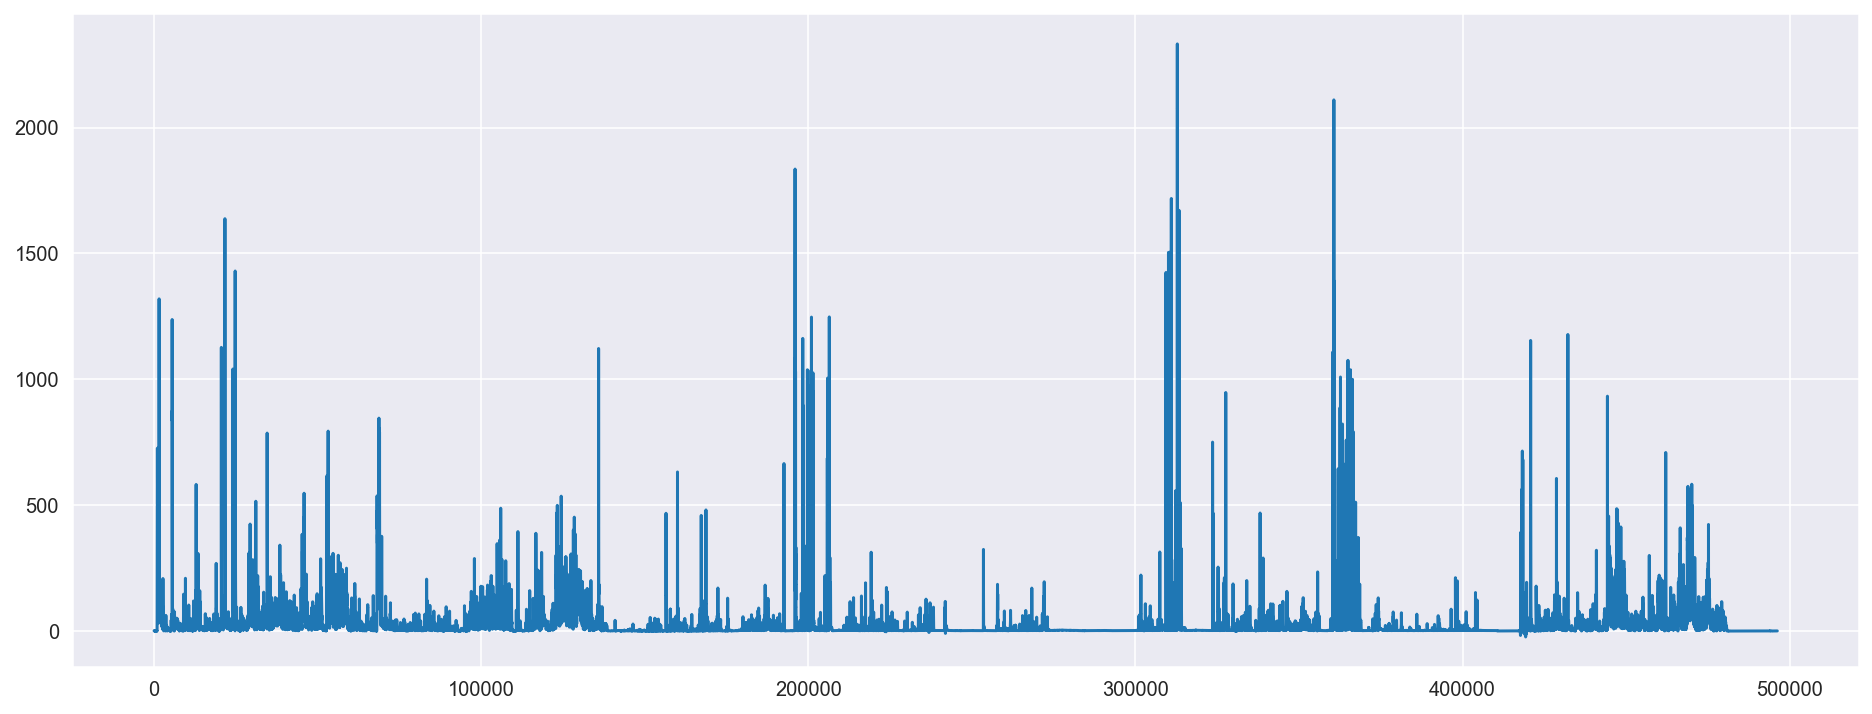

In [3]:
df['GPiS_NO'].plot()

In [4]:
df = df[(df['GPiS_NO']<500) &(df['GPiS_NO']>0)][:-2000]

In [5]:
channels_model = ['GPiS_NO','AMB_Humidity', 'AMB_Pressure', 'AMB_Temperature','EFM_ExhaustGasTemp',
                  'OBD_Accelerator_Pedal_Position_D_(PID_49)','OBD_Engine_Coolant_Temperature_(PID_05)',
                  'OBD_Engine_RPM_(PID_0C)','OBD_Vehicle_Speed_Sensor_(PID_0D)','accel']

In [6]:
df = df[channels_model].dropna()
df = df[df['OBD_Engine_Coolant_Temperature_(PID_05)']>0]
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel
1,0.592000,31.918452,962.843895,21.181047,17.978001,14.903600,20.0,0.00,0.0,0.0
2,0.593300,31.894226,962.843895,21.151974,18.100000,14.903600,20.0,0.00,0.0,0.0
3,0.595300,31.845775,962.843895,21.122906,18.100000,14.903600,20.0,0.00,0.0,0.0
4,0.596975,31.773098,962.843895,21.093832,18.100000,14.903600,20.0,0.00,0.0,0.0
5,0.598475,31.797323,962.601614,21.122906,18.100000,14.903600,20.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
480447,18.639870,42.341800,976.820755,-4.895972,68.288002,18.820801,95.0,1215.00,26.0,0.0
480448,17.270870,42.341800,976.820755,-4.867365,68.400002,18.820801,95.0,1215.00,26.0,0.0
480449,17.113434,42.365642,977.059174,-4.867365,68.400002,18.820801,95.0,1215.00,26.0,0.0
480450,16.955997,42.341800,976.820755,-4.867365,68.400002,21.173401,95.0,1215.00,26.0,0.0


In [7]:
# reduce_by = 10
# df = df.groupby(df.index//reduce_by).mean()
# df.shape

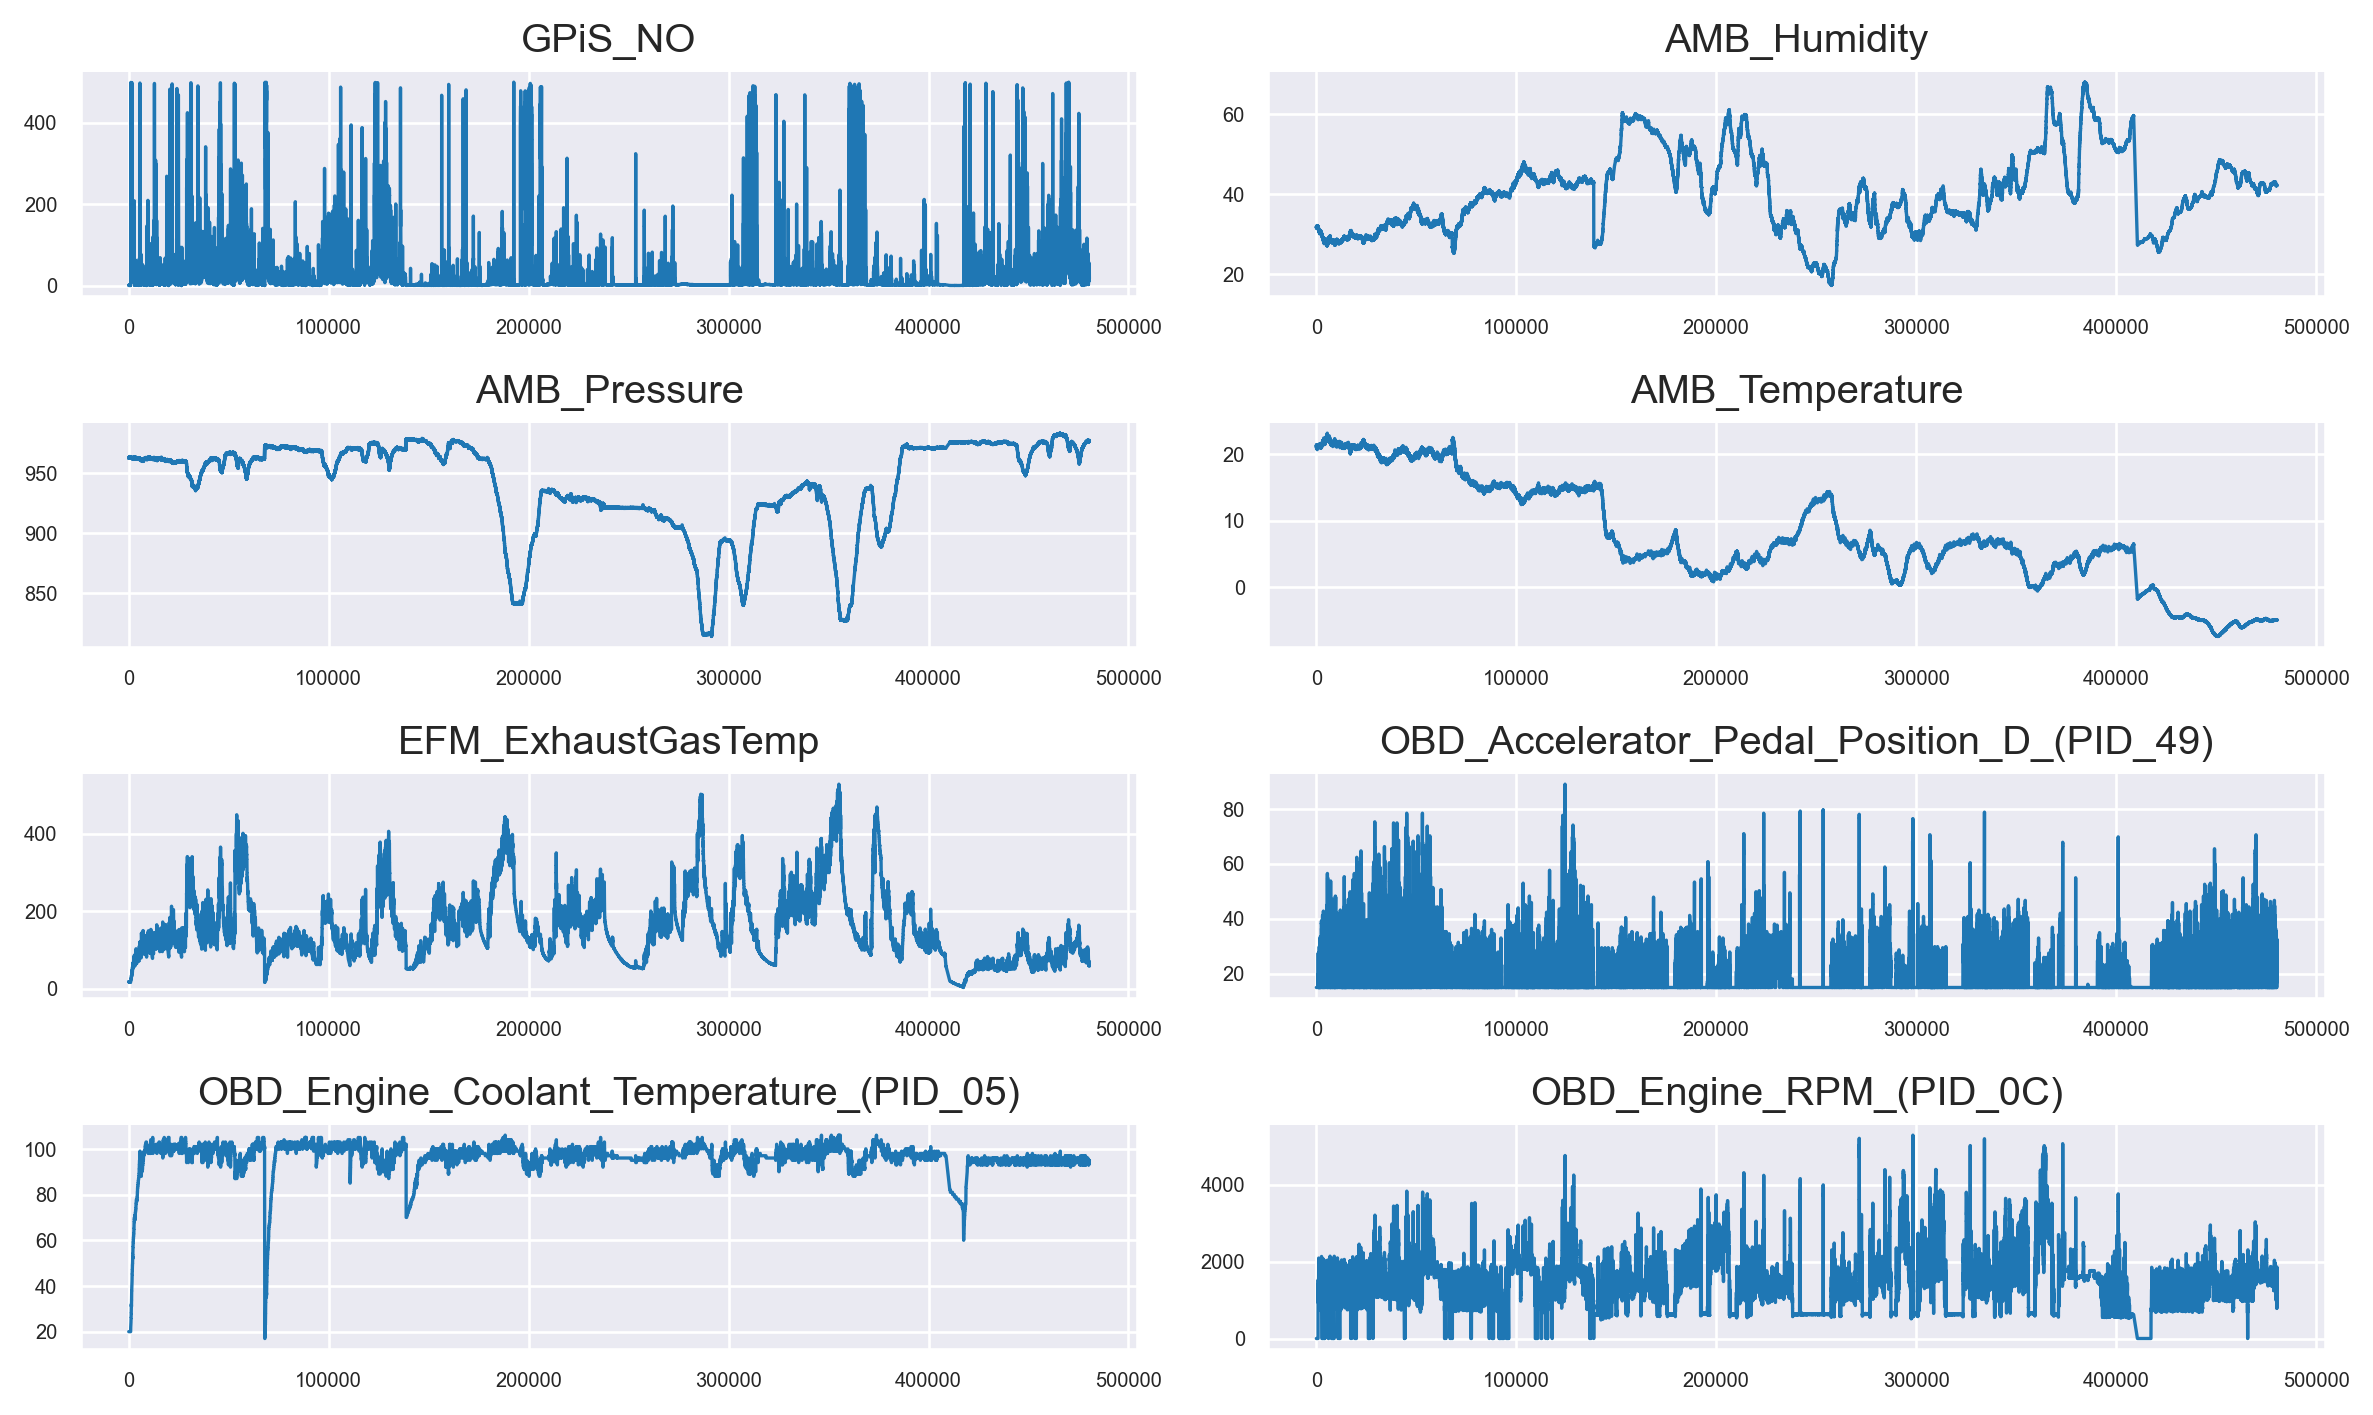

In [8]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data,linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Granger causality 
The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another

In [33]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df.dropna(), variables = df.columns)  

,GPiS_NO_x,AMB_Humidity_x,AMB_Pressure_x,AMB_Temperature_x,EFM_ExhaustGasTemp_x,OBD_Accelerator_Pedal_Position_D_(PID_49)_x,OBD_Engine_Coolant_Temperature_(PID_05)_x,OBD_Engine_RPM_(PID_0C)_x,OBD_Vehicle_Speed_Sensor_(PID_0D)_x,accel_x
GPiS_NO_y,0.9992,0.1655,0.0000,0.0002,0.0,0.0000,0.0,0.0000,0.0000,0.1025
AMB_Humidity_y,0.2644,1.0000,0.0000,0.0000,0.0,0.0696,0.0,0.0000,0.0000,0.0410
AMB_Pressure_y,0.0000,0.0000,1.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000
AMB_Temperature_y,0.4572,0.0000,0.0002,1.0000,0.0,0.0007,0.0,0.0439,0.0004,0.1782
EFM_ExhaustGasTemp_y,0.0000,0.0000,0.0000,0.0039,1.0,0.0000,0.0,0.0000,0.0000,0.0000
OBD_Accelerator_Pedal_Position_D_(PID_49)_y,0.0000,0.4244,0.0000,0.0665,0.0,1.0000,0.0,0.0000,0.0000,0.0000
OBD_Engine_Coolant_Temperature_(PID_05)_y,0.0000,0.0212,0.0005,0.0420,0.0,0.0000,1.0,0.0000,0.0000,0.0000
OBD_Engine_RPM_(PID_0C)_y,0.0000,0.0000,0.0000,0.0178,0.0,0.0000,0.0,1.0000,0.0000,0.0000
OBD_Vehicle_Speed_Sensor_(PID_0D)_y,0.0000,0.1543,0.0000,0.3686,0.0,0.0000,0.0,0.0000,1.0000,0.0000
accel_y,0.0008,0.0689,0.0000,0.3940,0.0,0.0000,0.0,0.0000,0.0000,0.9945


## Train test split

In [10]:
split = int(len(df)*0.1) # 90-10 split
train, test = df[0:-split], df[-split:]

# Check shape
print(train.shape)
print(test.shape)  

(414767, 10)
(46085, 10)


## Check for Stationarity

In [11]:
def tsplot(y,name='', lags=None, figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(name)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

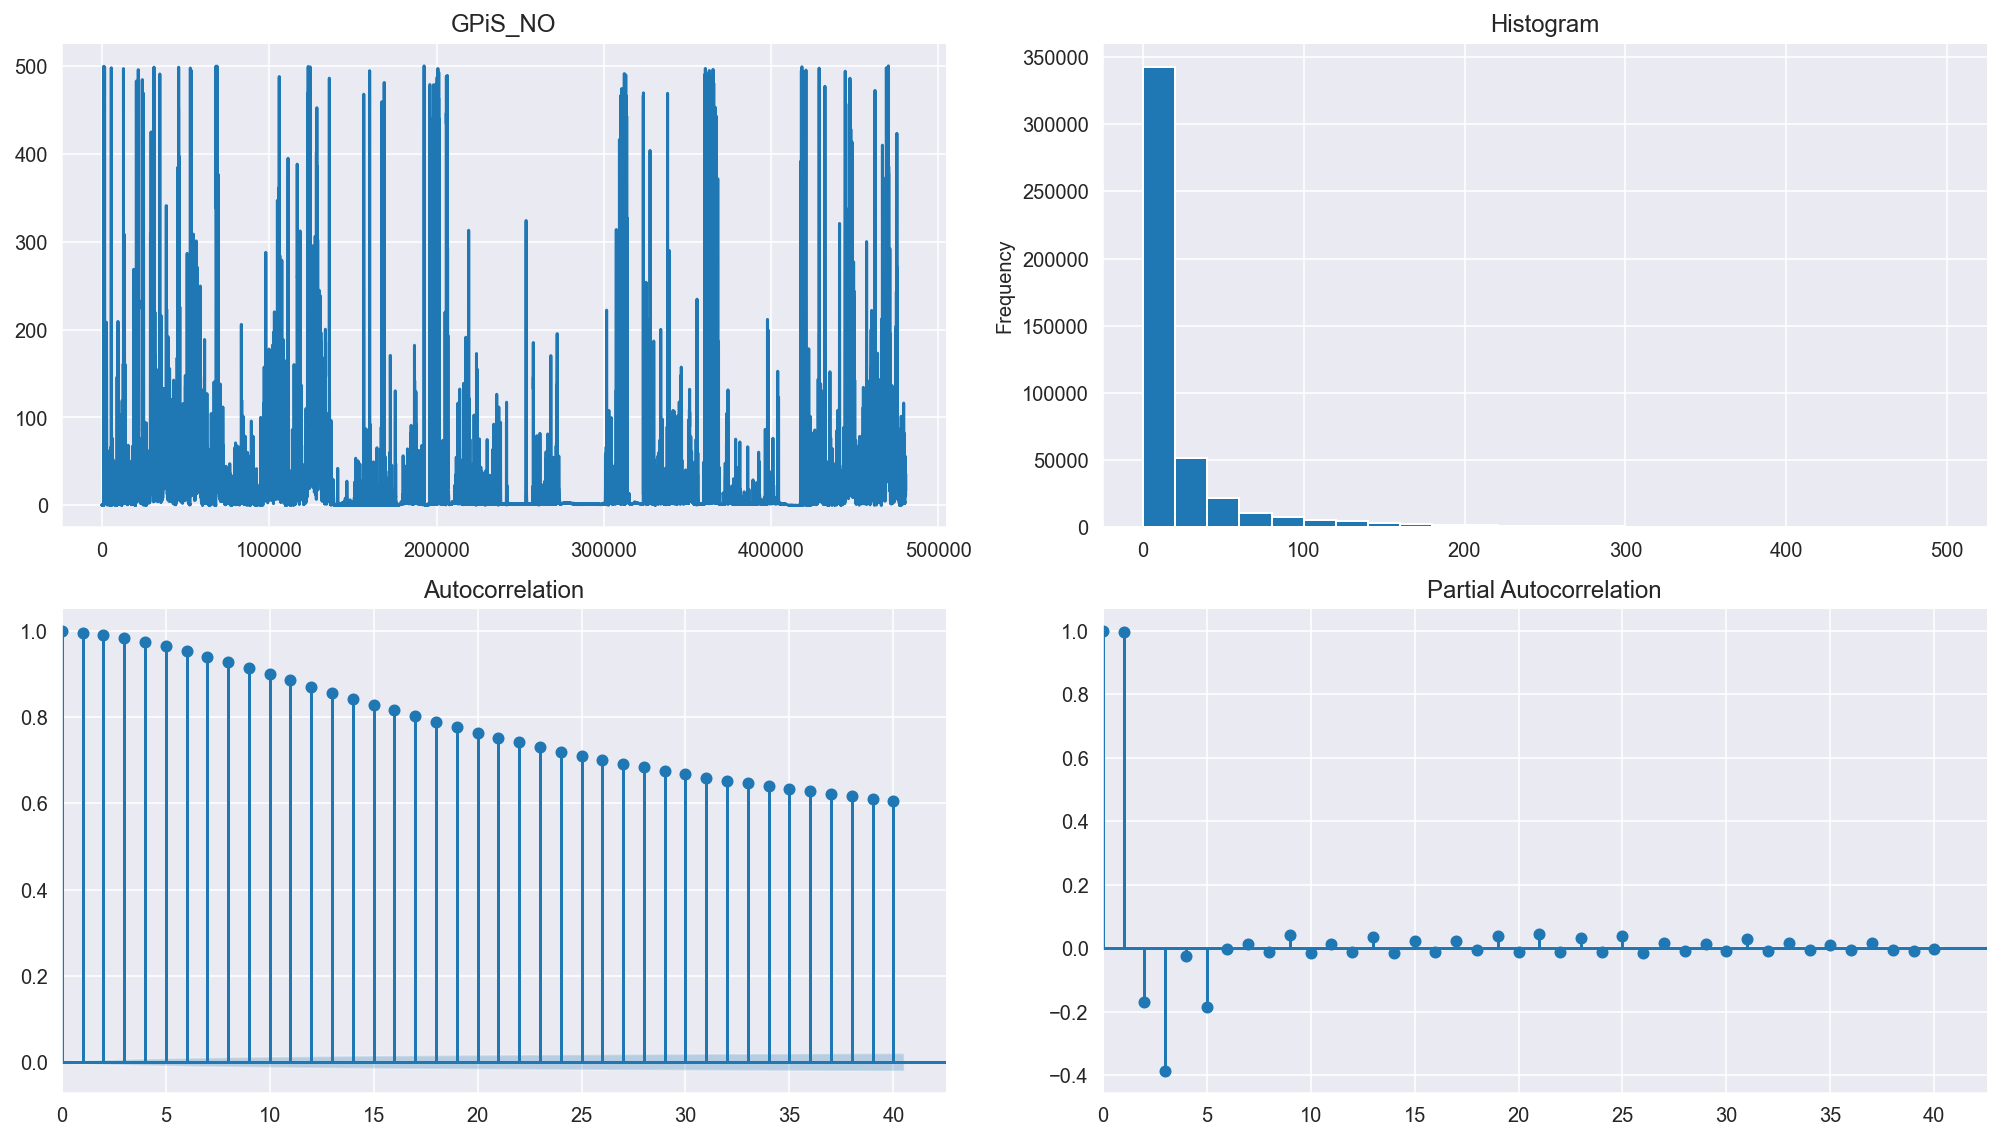

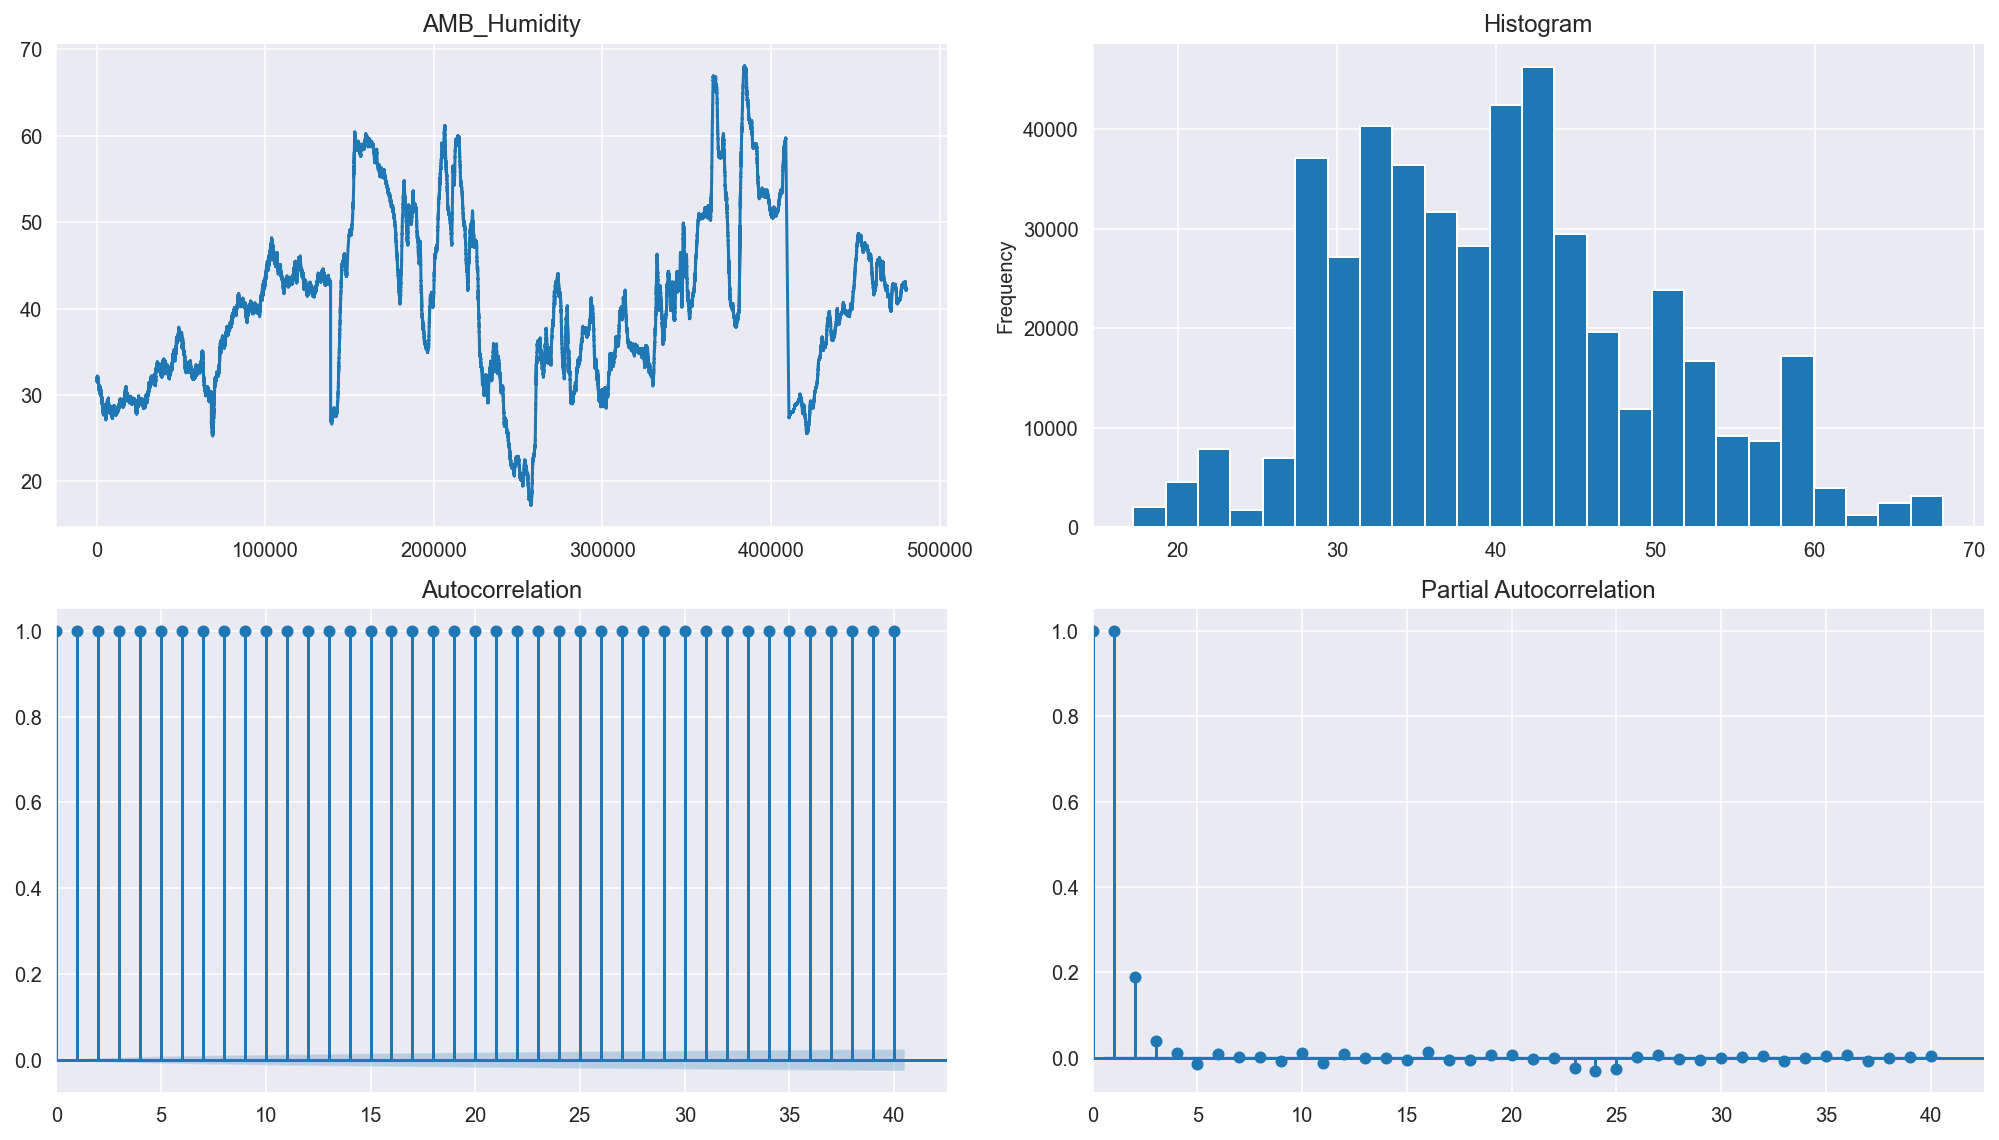

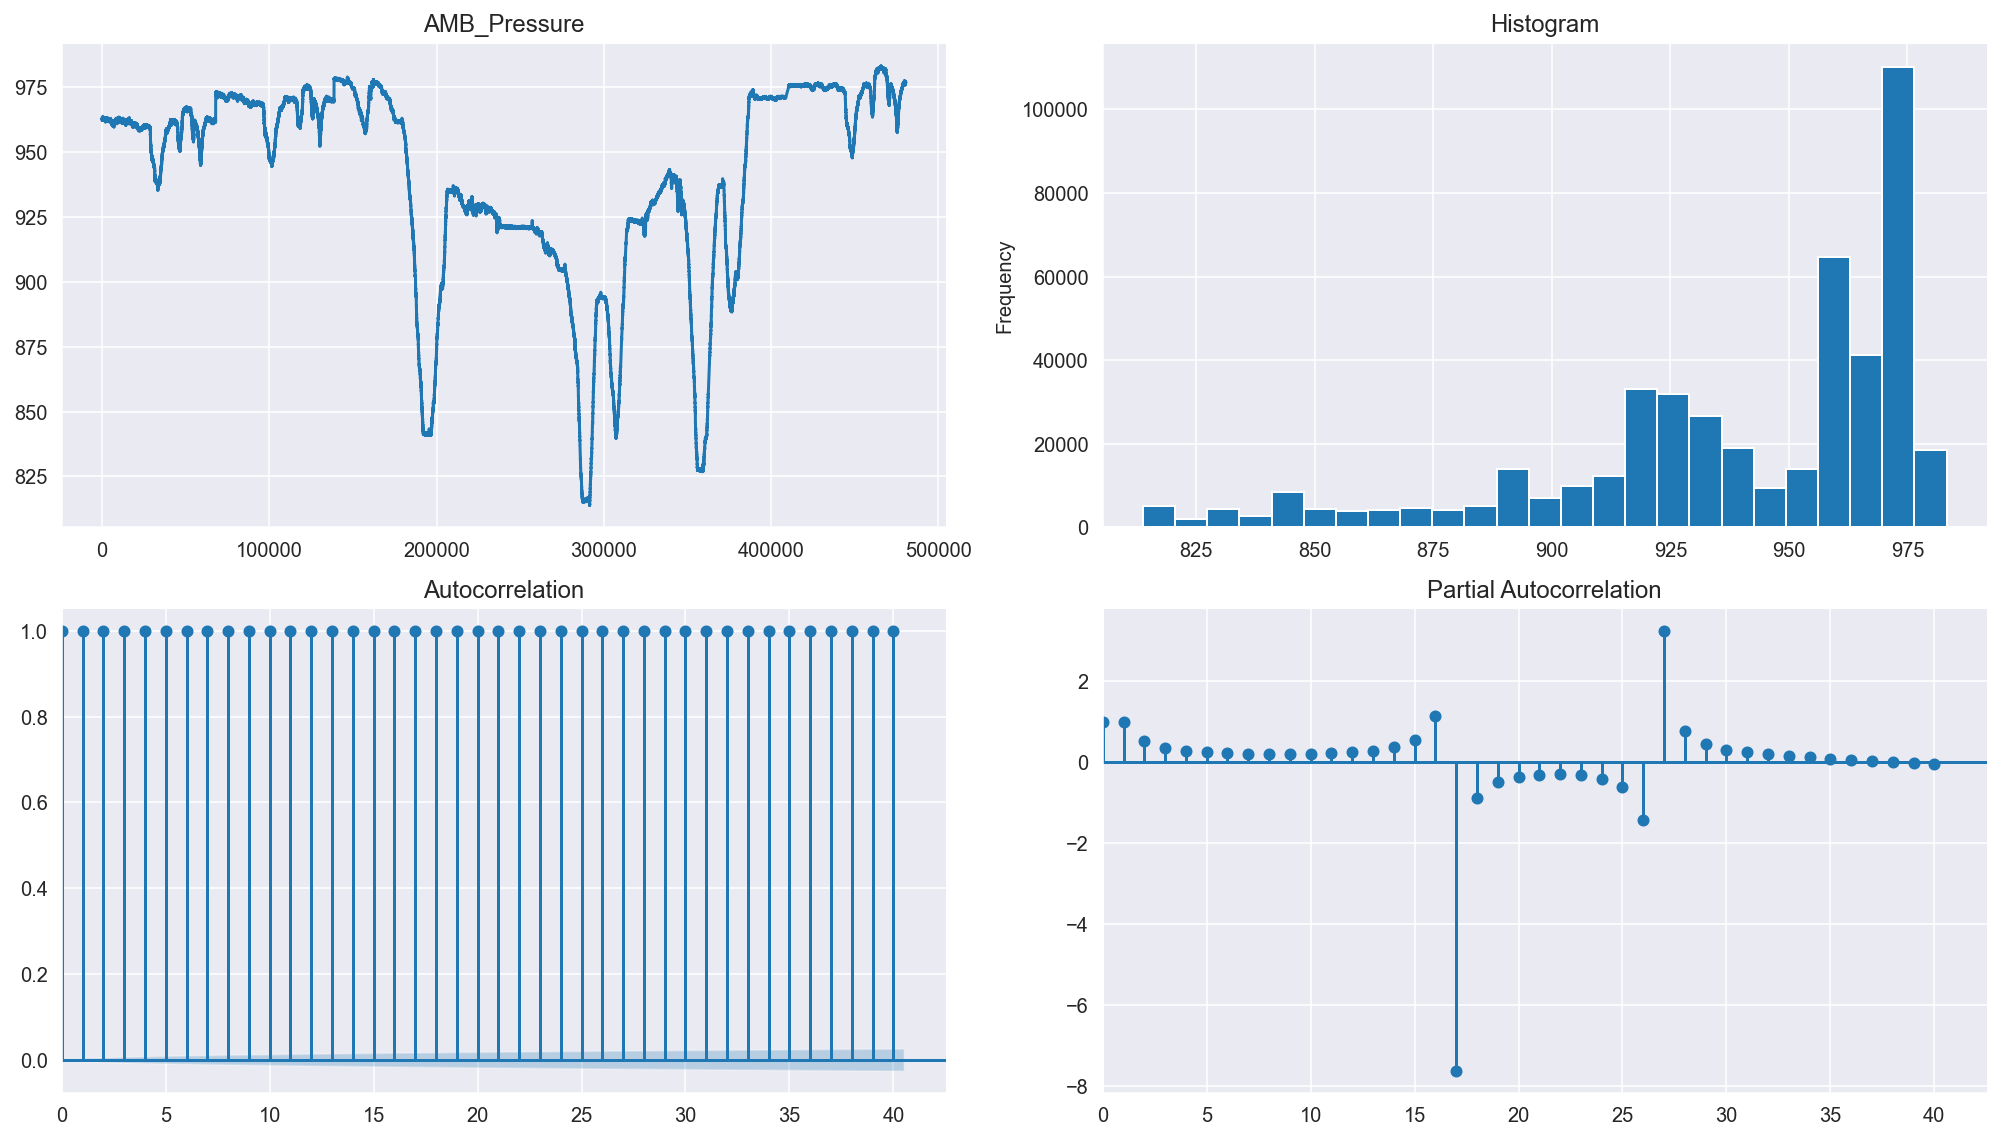

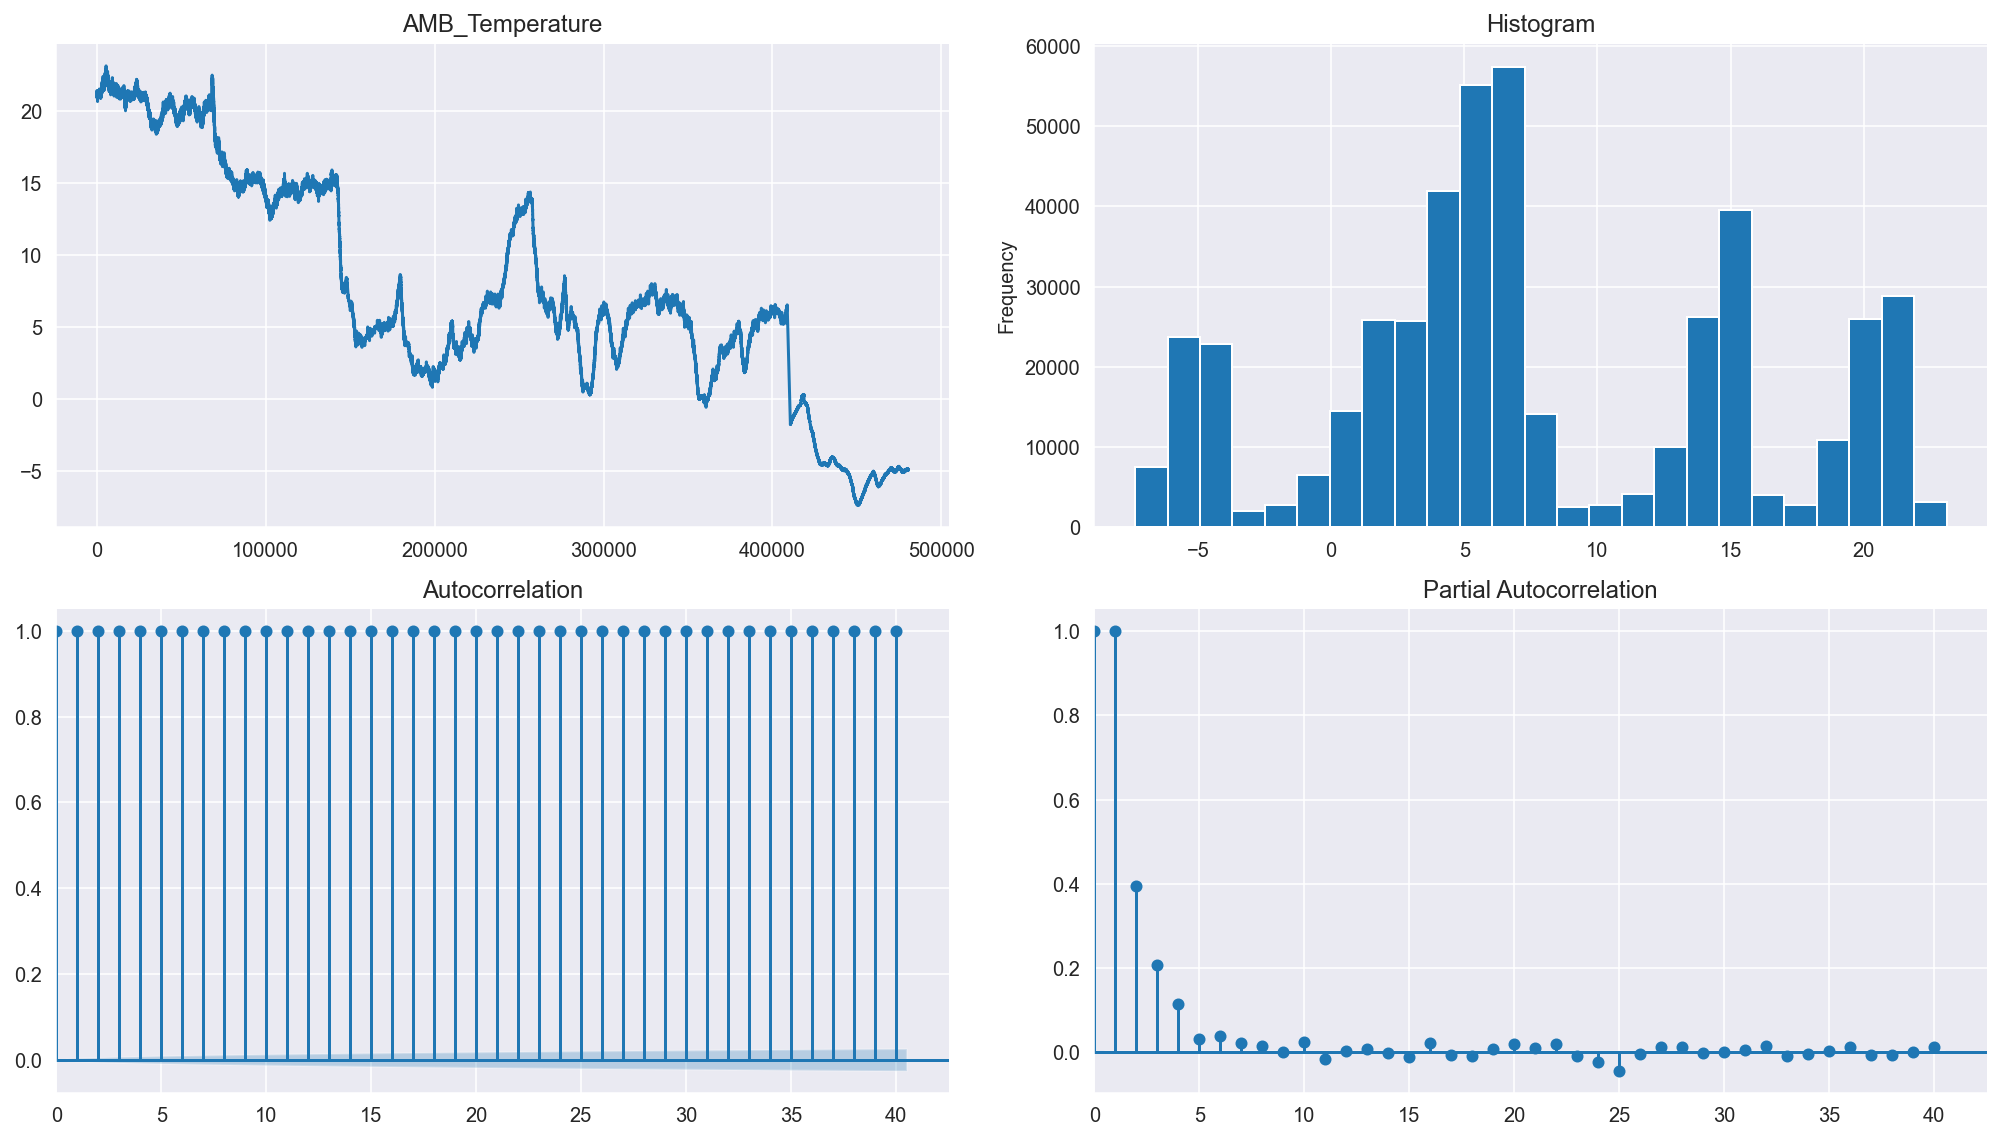

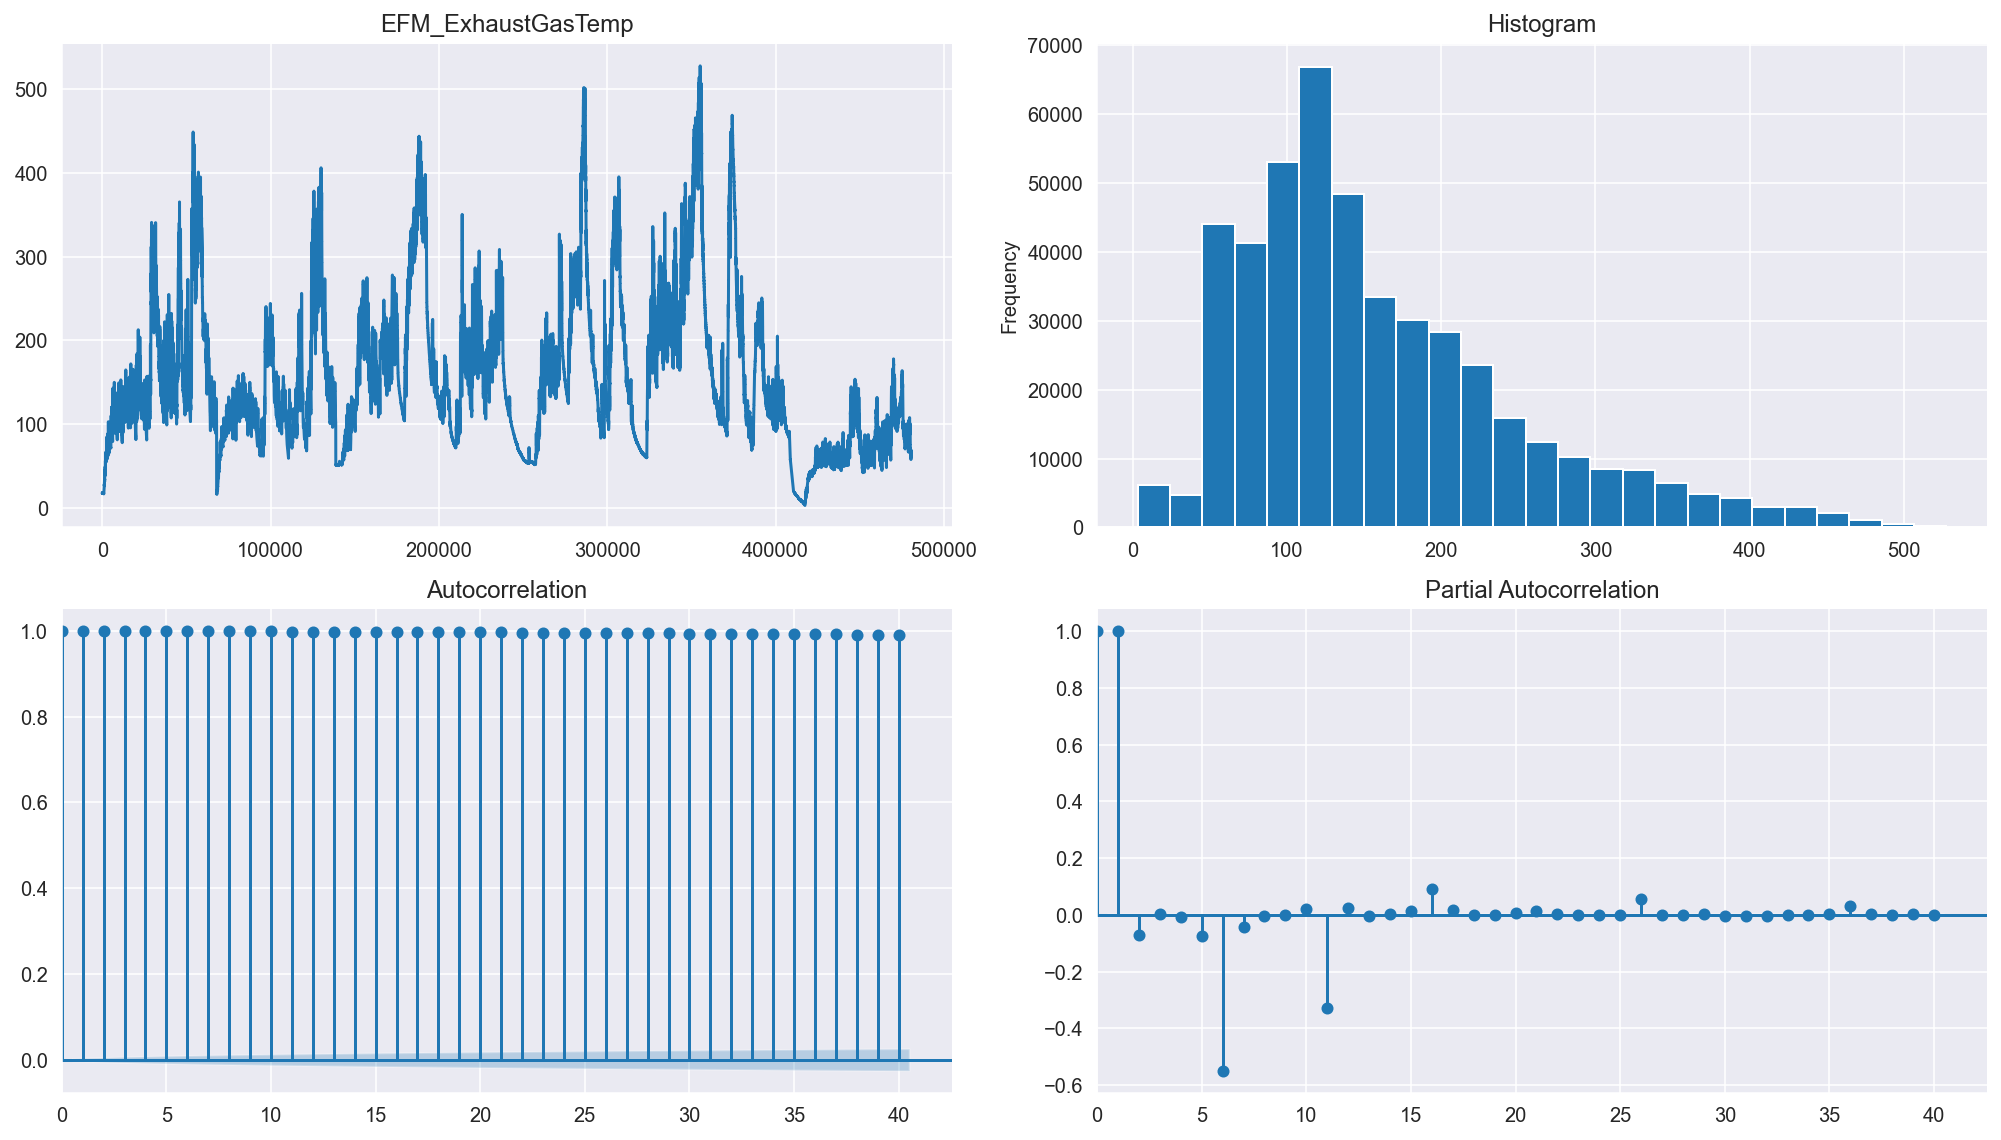

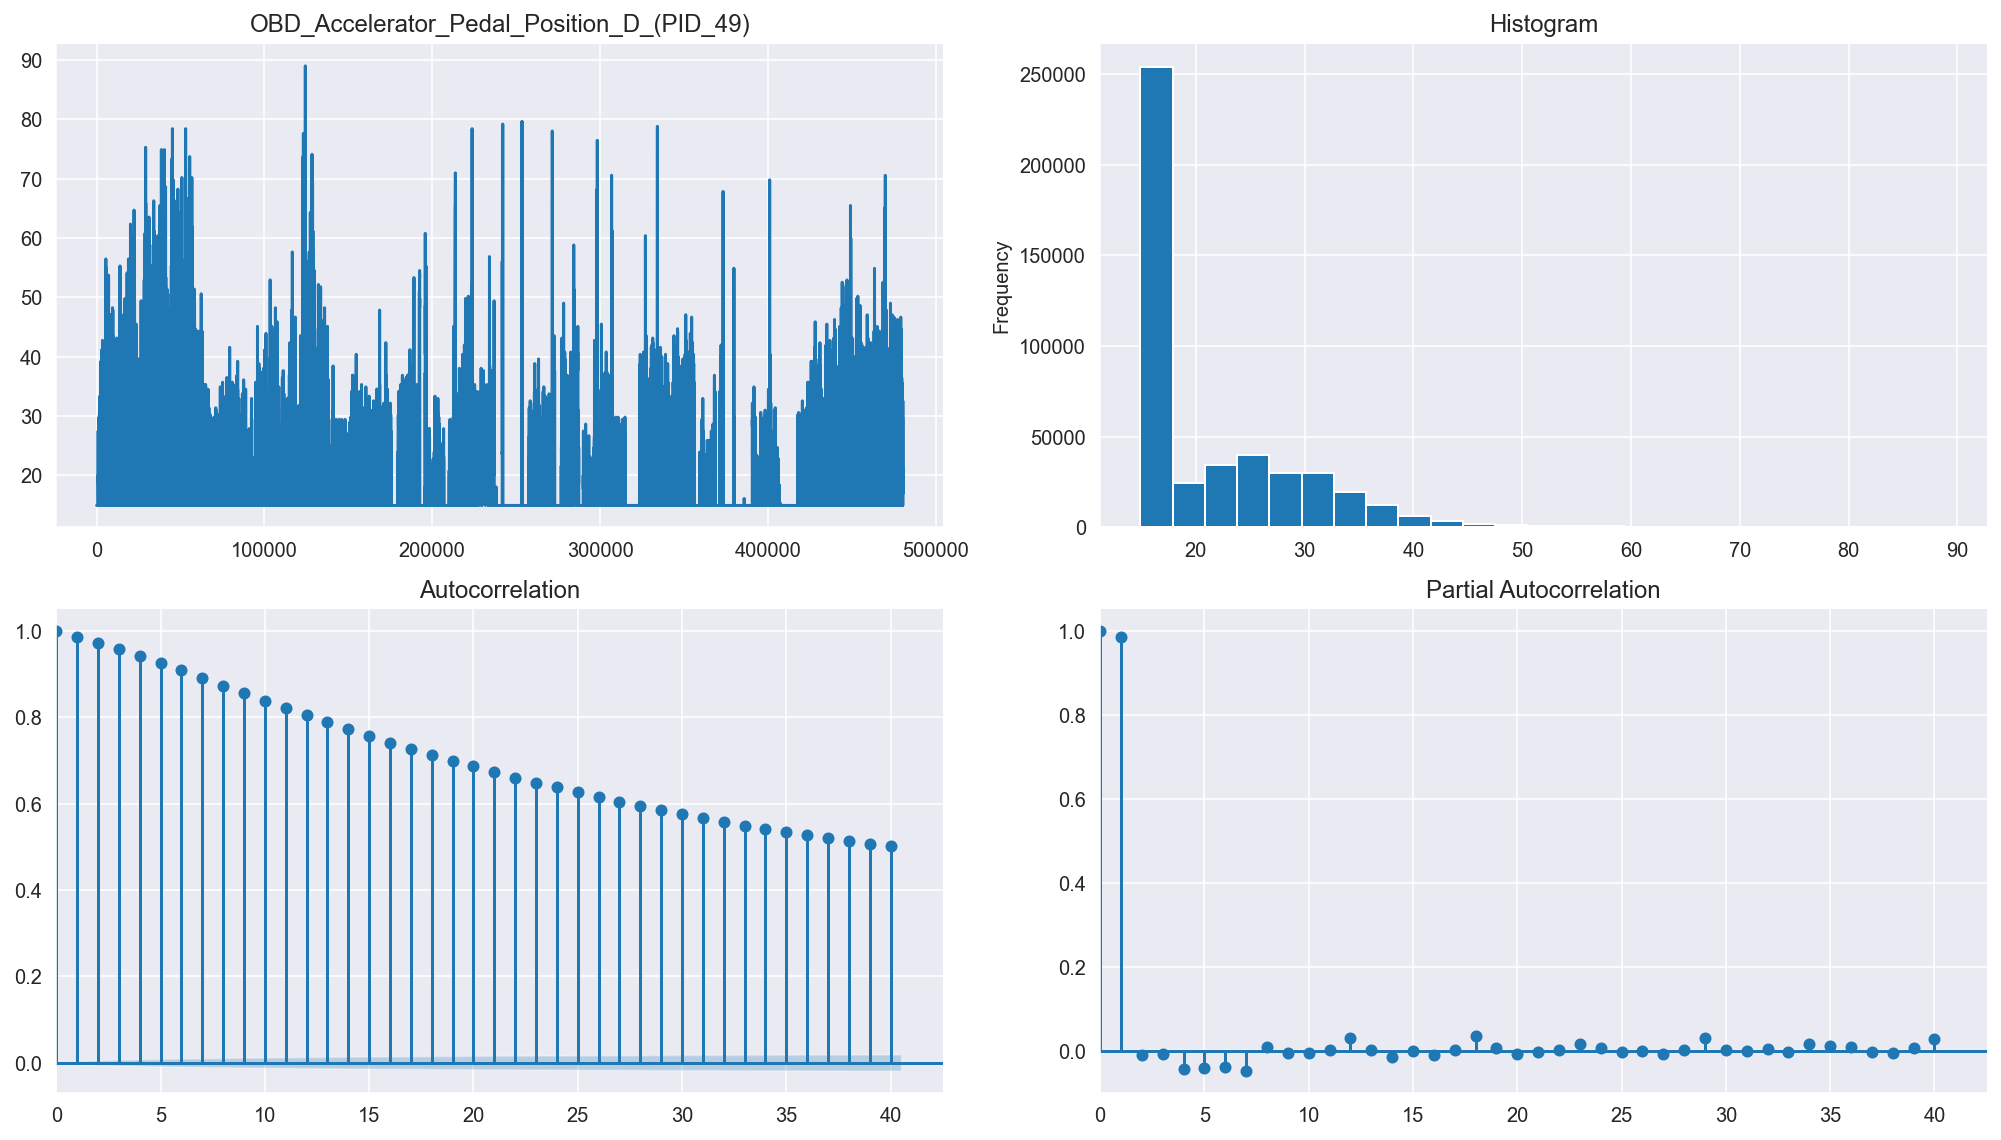

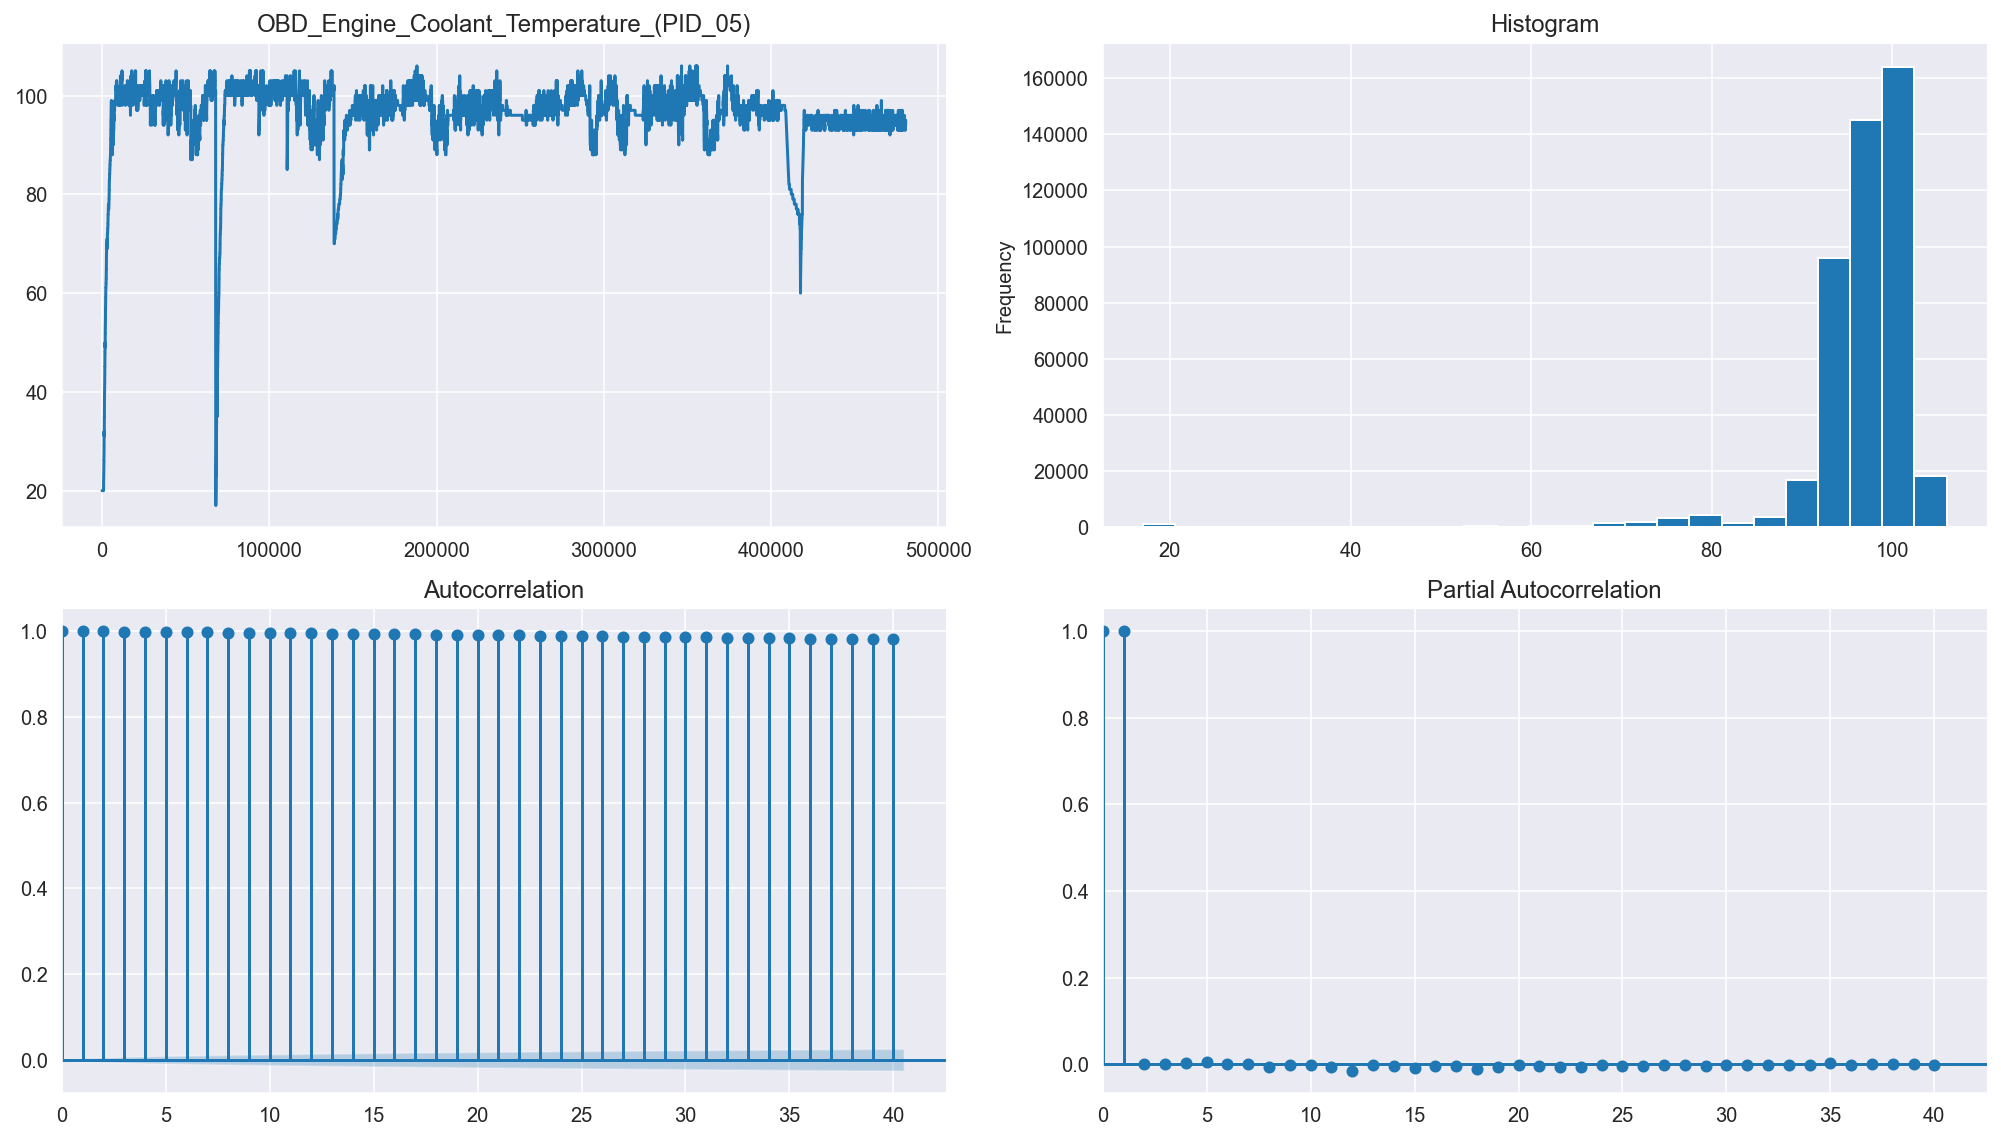

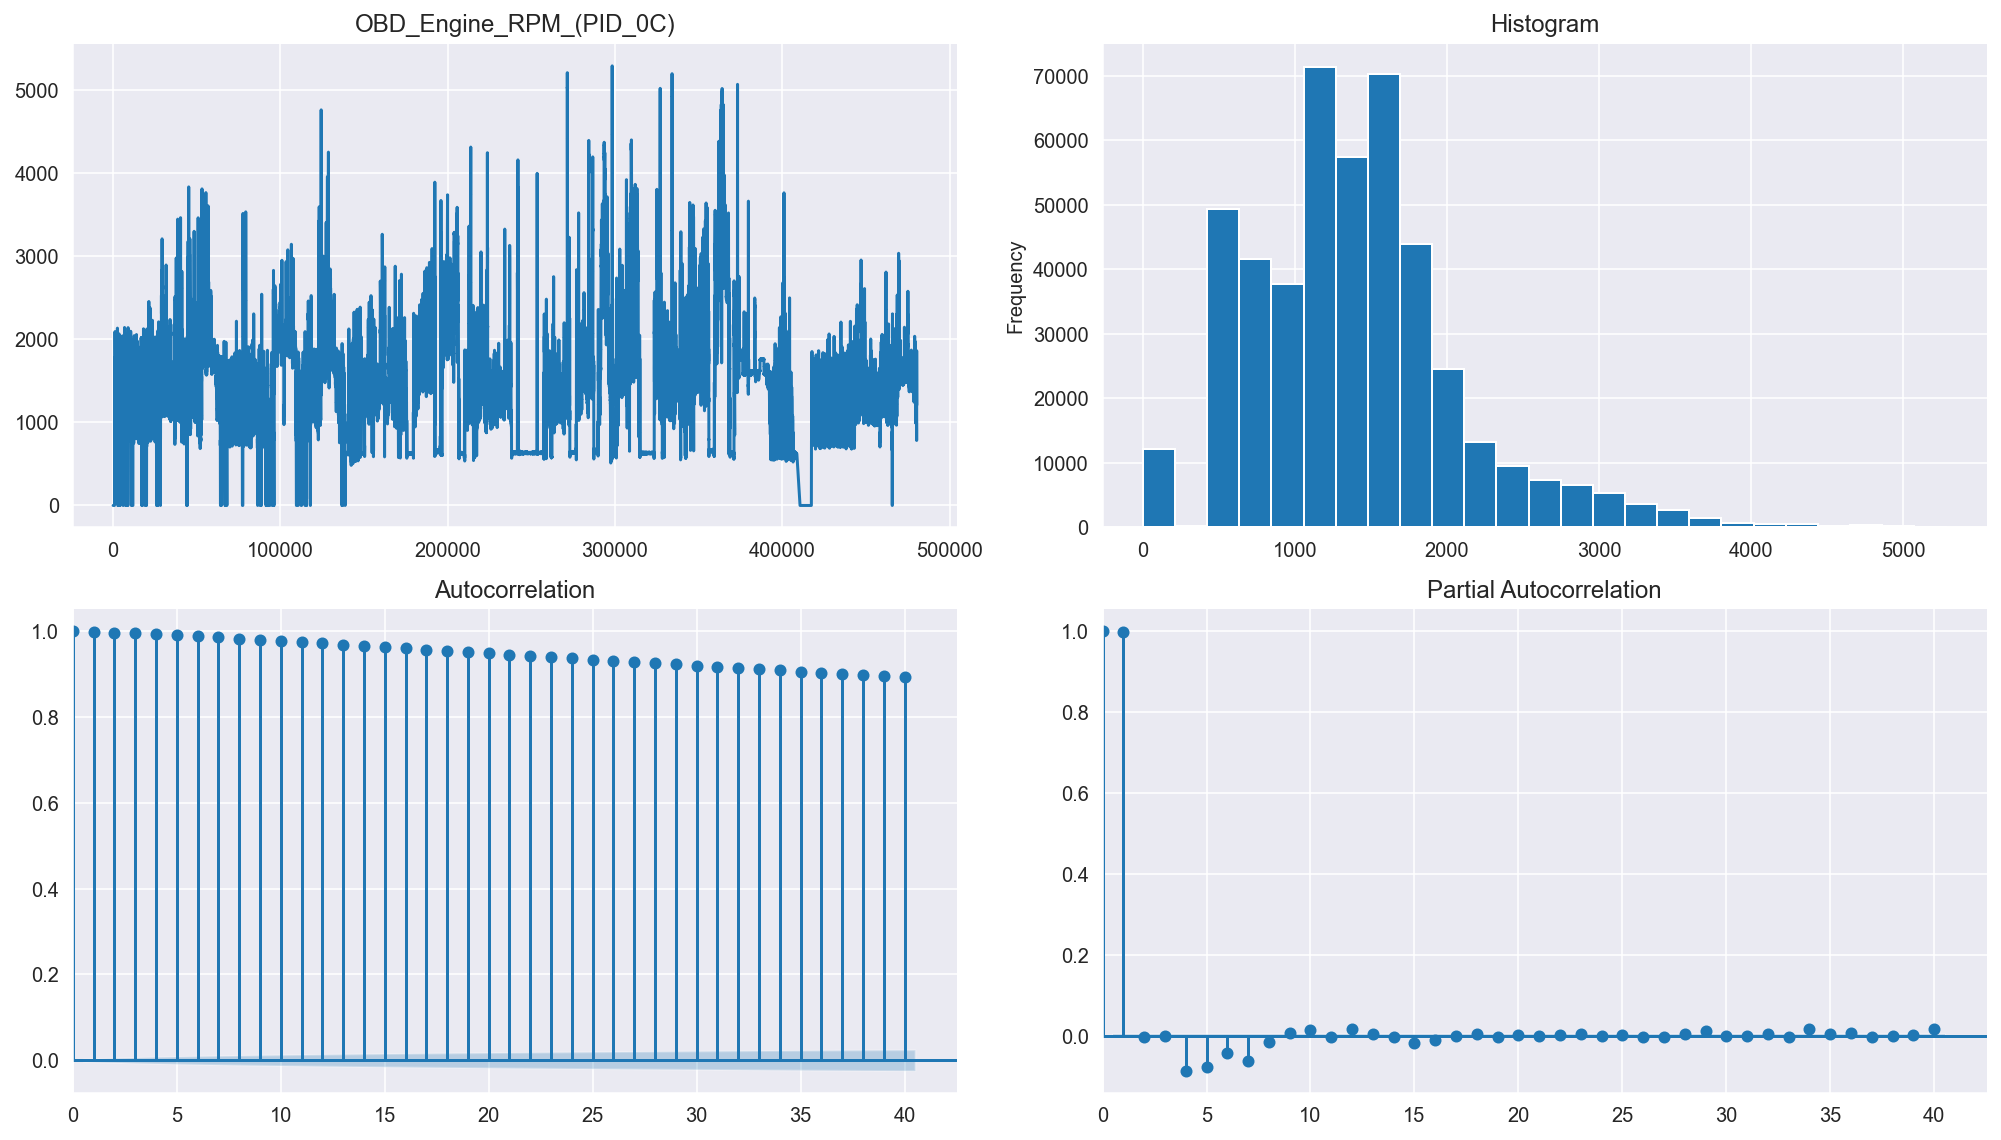

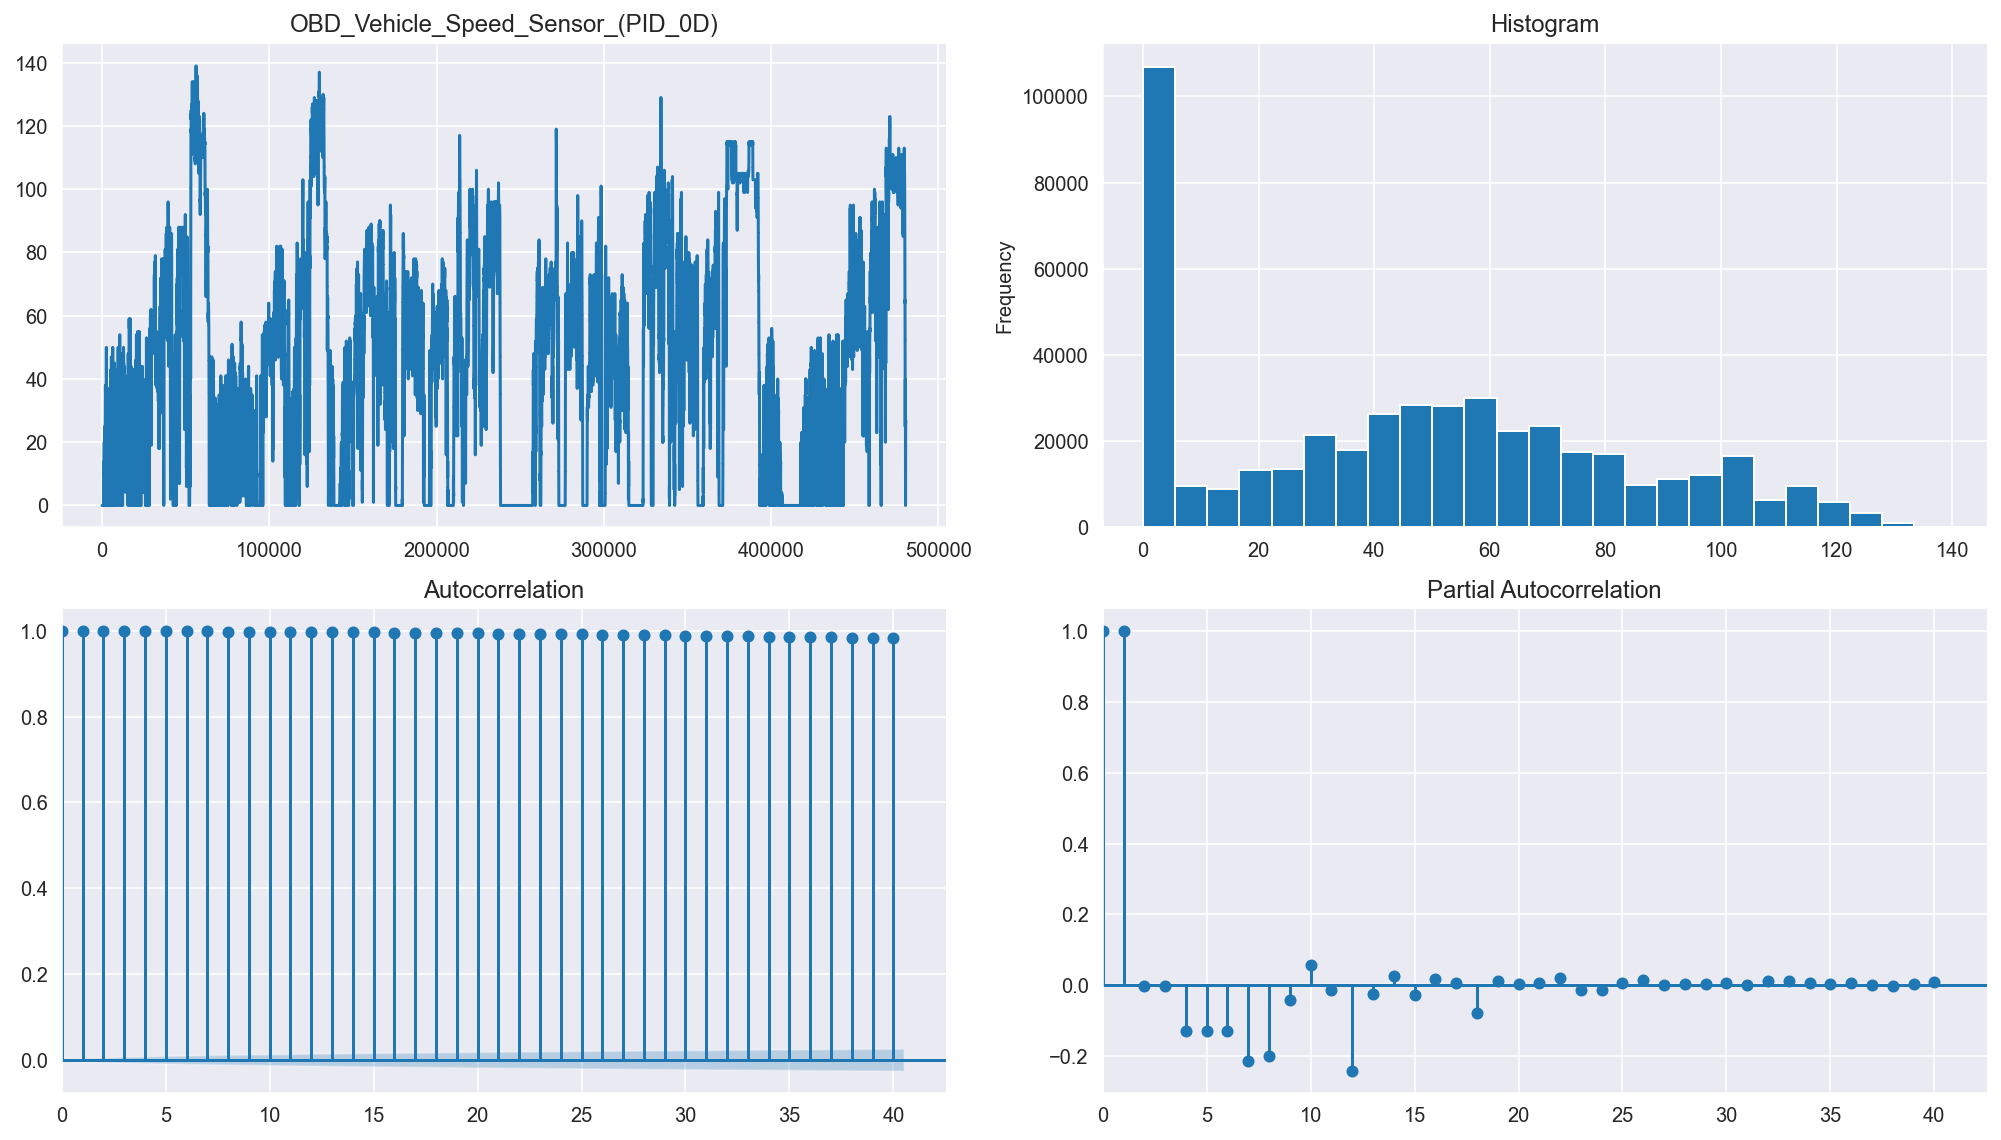

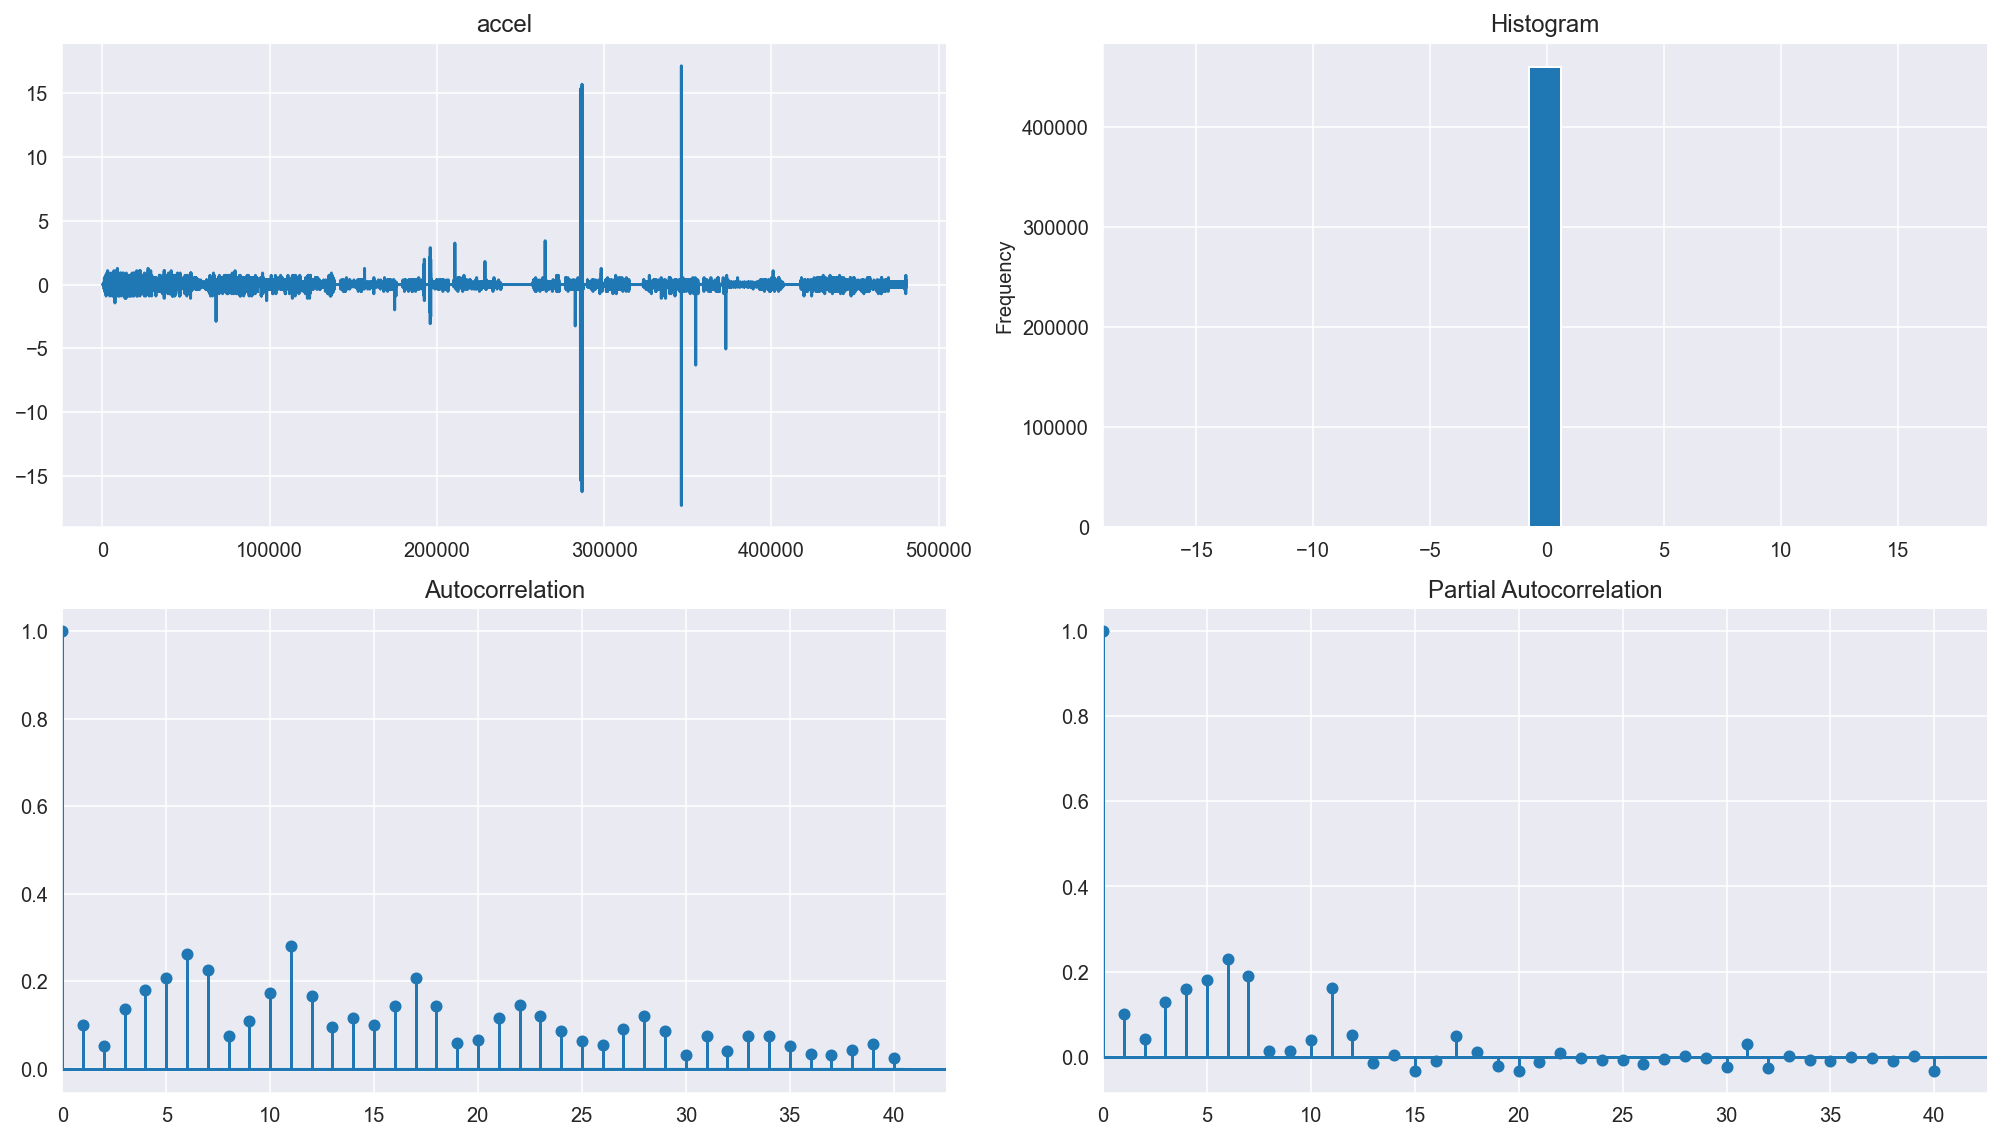

In [34]:
for name, column in df.iteritems():
    tsplot(column, name=column.name, lags=40)

In [13]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, name='', **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f' KPSS Test on "{name}"', "\n   ", '-'*47)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [14]:
# KPSS  Test on each column
for name, column in train.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

 KPSS Test on "GPiS_NO" 
    -----------------------------------------------
KPSS Statistic: 31.219770180082275
p-value: 0.01
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


 KPSS Test on "AMB_Humidity" 
    -----------------------------------------------
KPSS Statistic: 38.51010280267356
p-value: 0.01
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


 KPSS Test on "AMB_Pressure" 
    -----------------------------------------------
KPSS Statistic: 101.05625424171689
p-value: 0.01
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


 KPSS Test on "AMB_Temperature" 
    -----------------------------------------------
KPSS Statistic: 298.4278994343086
p-value: 0.01
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The

In [15]:
# 1st difference
df_diff = train.diff().dropna()

In [16]:
# ADF Test on difference columns
for name, column in df_diff.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

 KPSS Test on "GPiS_NO" 
    -----------------------------------------------
KPSS Statistic: 0.0002407716125321197
p-value: 0.1
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


 KPSS Test on "AMB_Humidity" 
    -----------------------------------------------
KPSS Statistic: 0.06419765828302103
p-value: 0.1
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


 KPSS Test on "AMB_Pressure" 
    -----------------------------------------------
KPSS Statistic: 1.1957374015781603
p-value: 0.01
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


 KPSS Test on "AMB_Temperature" 
    -----------------------------------------------
KPSS Statistic: 0.1673980063813967
p-value: 0.1
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The seri

In [17]:
# 2 difference
df_diff2 = df_diff.diff().dropna()

In [18]:
# ADF Test on 2 order difference columns
for name, column in df_diff2.iteritems():
    kpss_test(column, name=column.name)
    print('\n')

 KPSS Test on "GPiS_NO" 
    -----------------------------------------------
KPSS Statistic: 0.00011650618394502903
p-value: 0.1
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


 KPSS Test on "AMB_Humidity" 
    -----------------------------------------------
KPSS Statistic: 0.00012208397414447889
p-value: 0.1
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


 KPSS Test on "AMB_Pressure" 
    -----------------------------------------------
KPSS Statistic: 0.00011817547141612735
p-value: 0.1
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


 KPSS Test on "AMB_Temperature" 
    -----------------------------------------------
KPSS Statistic: 0.0001272078512129751
p-value: 0.1
num lags: 97
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: Th

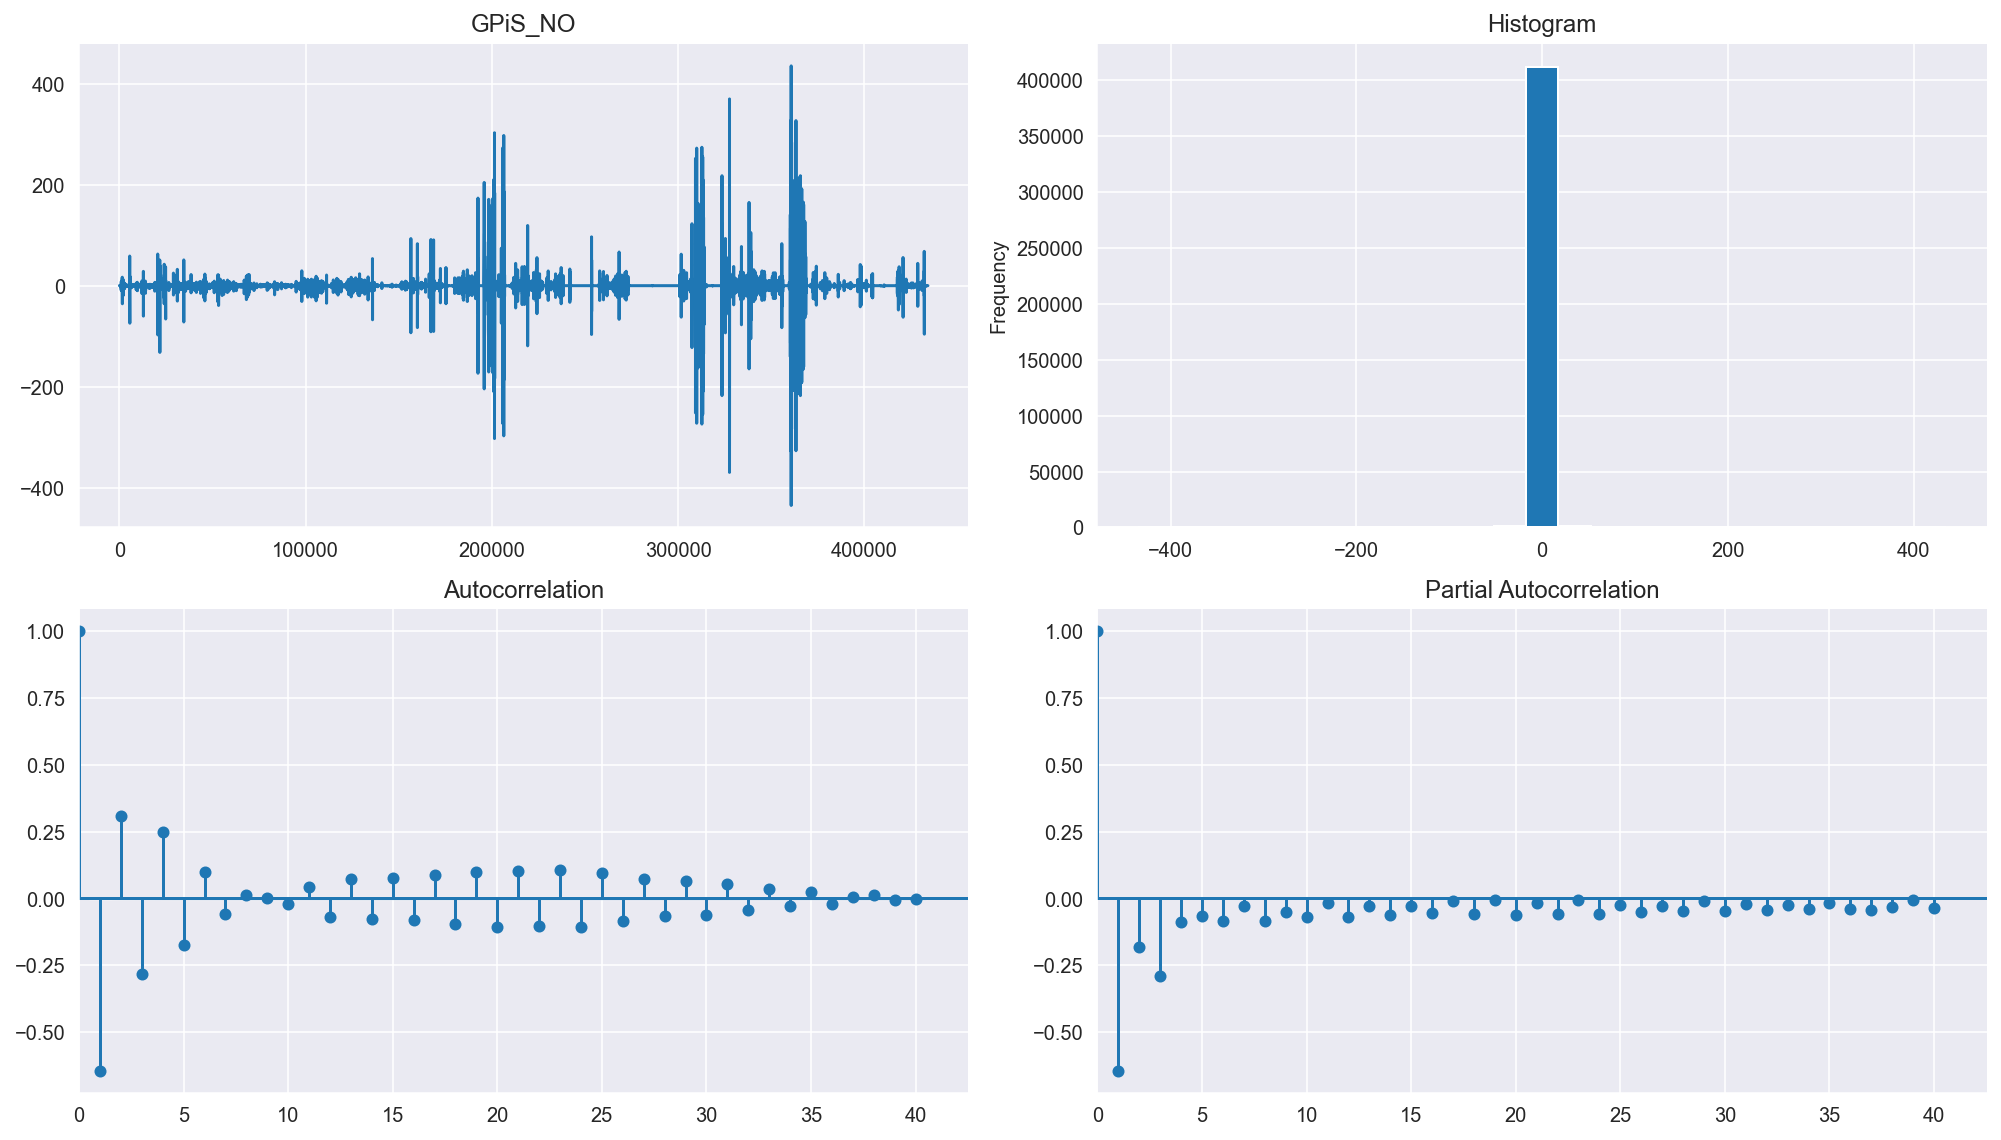

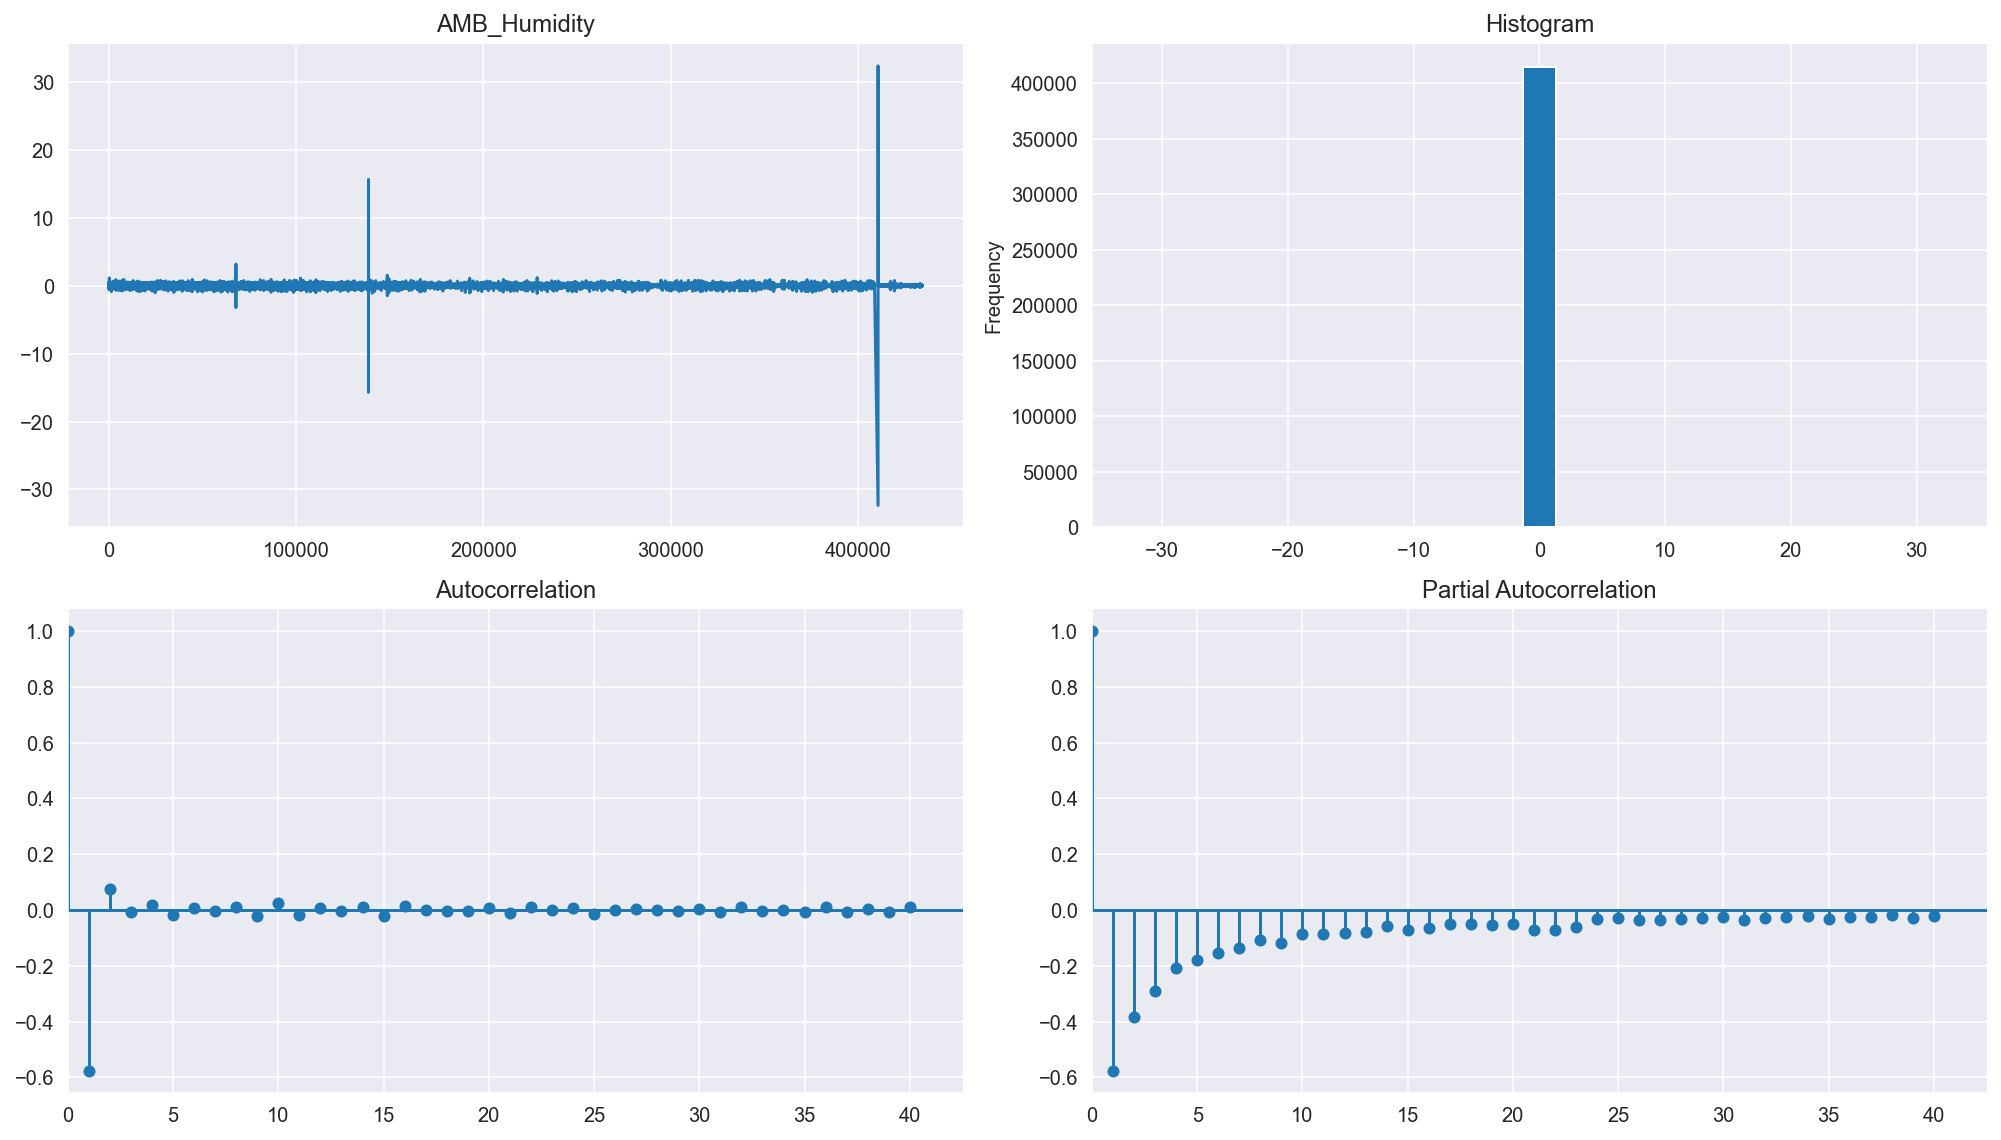

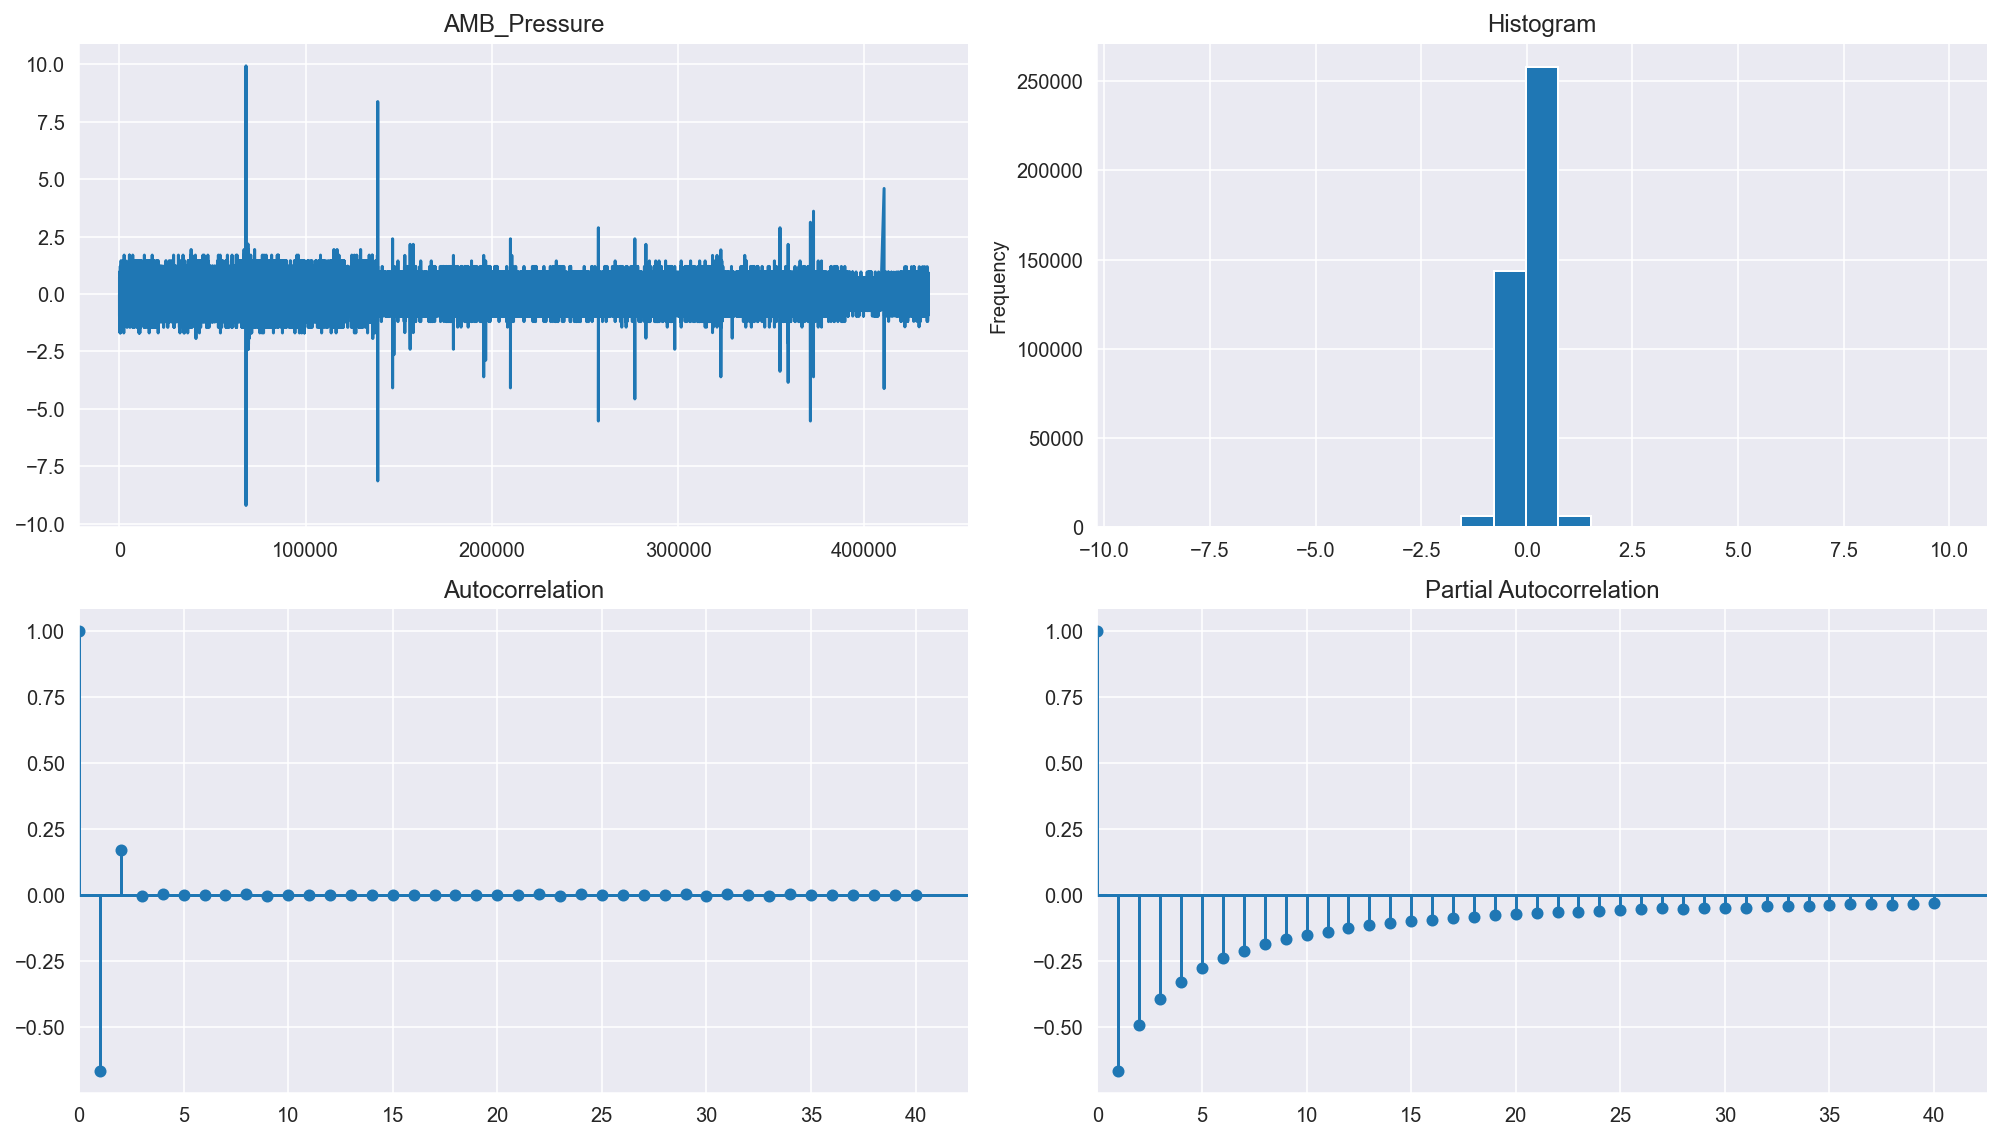

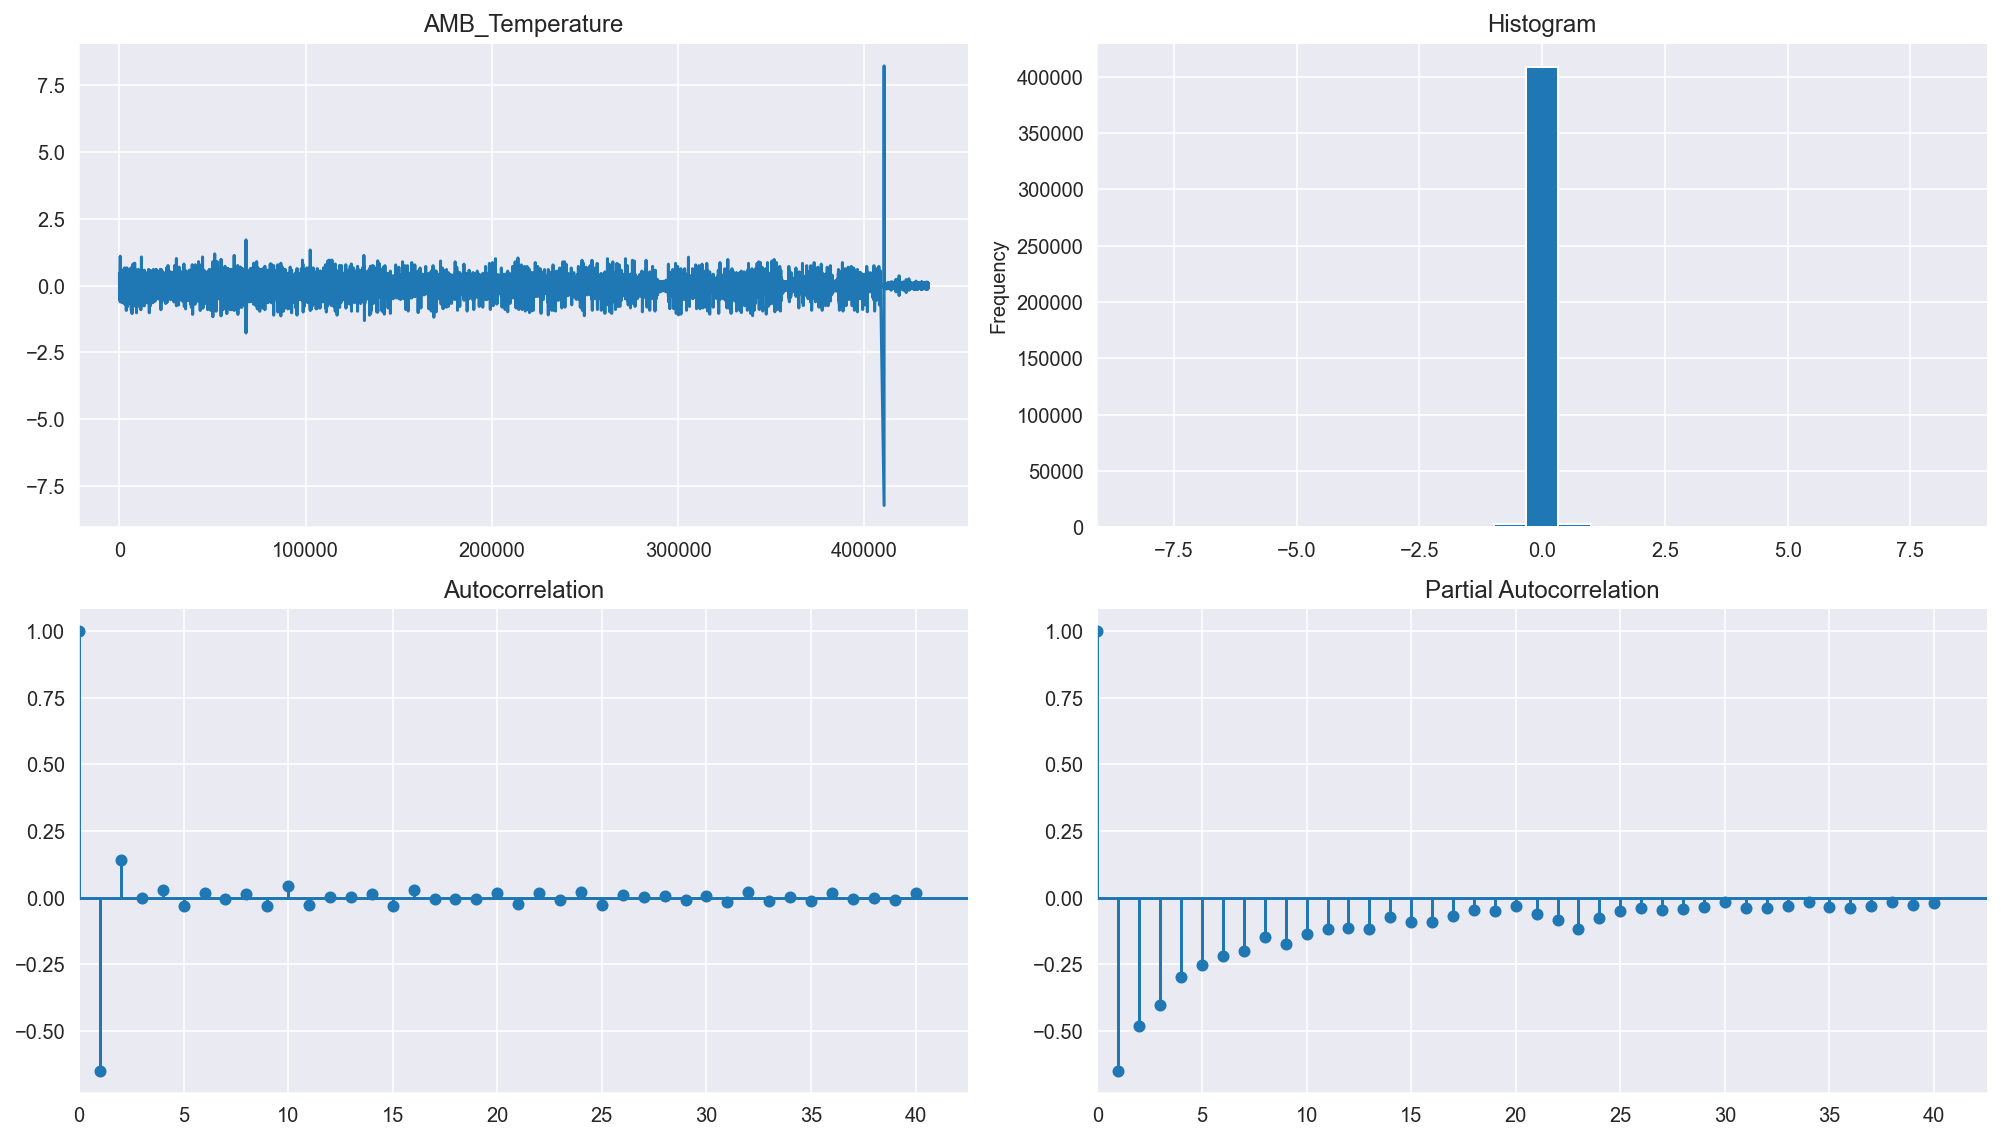

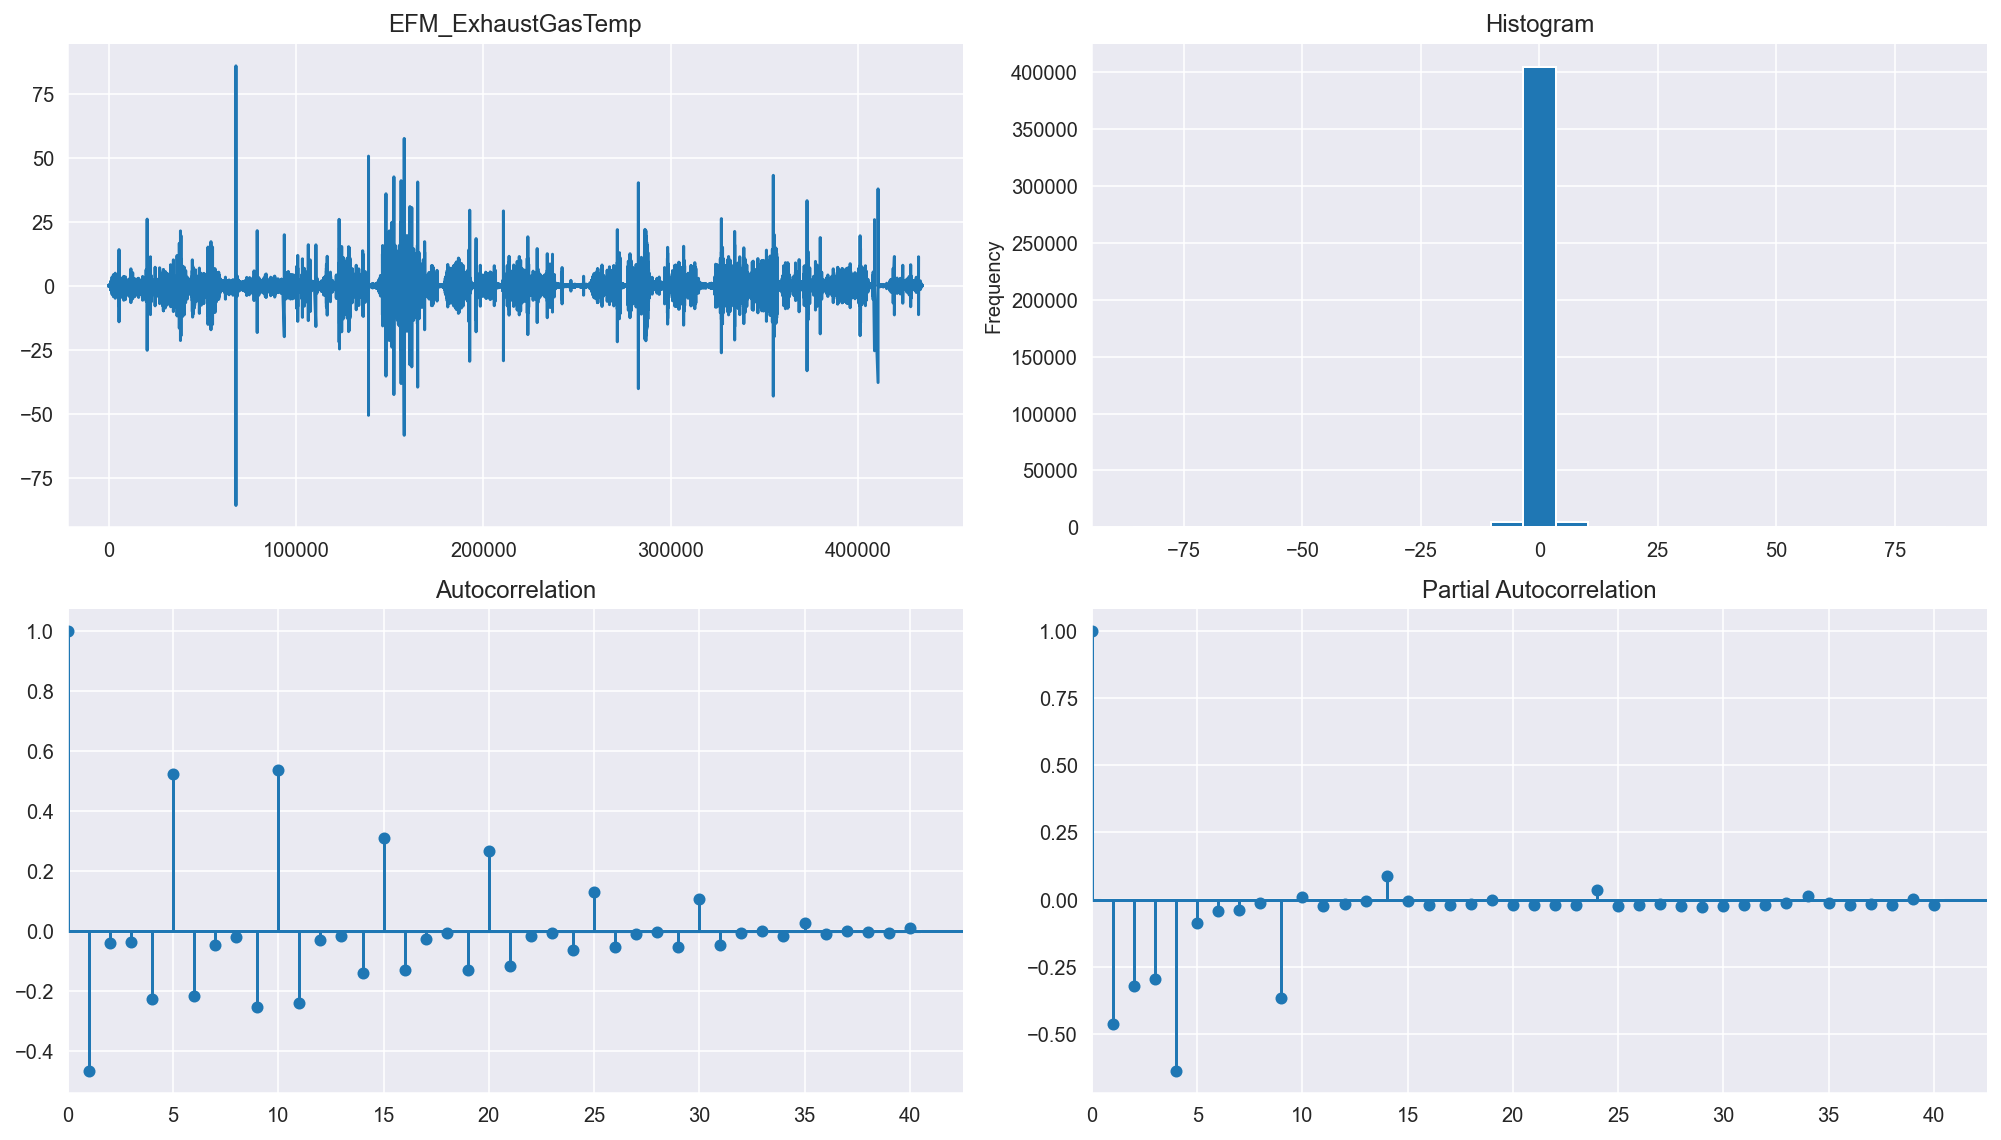

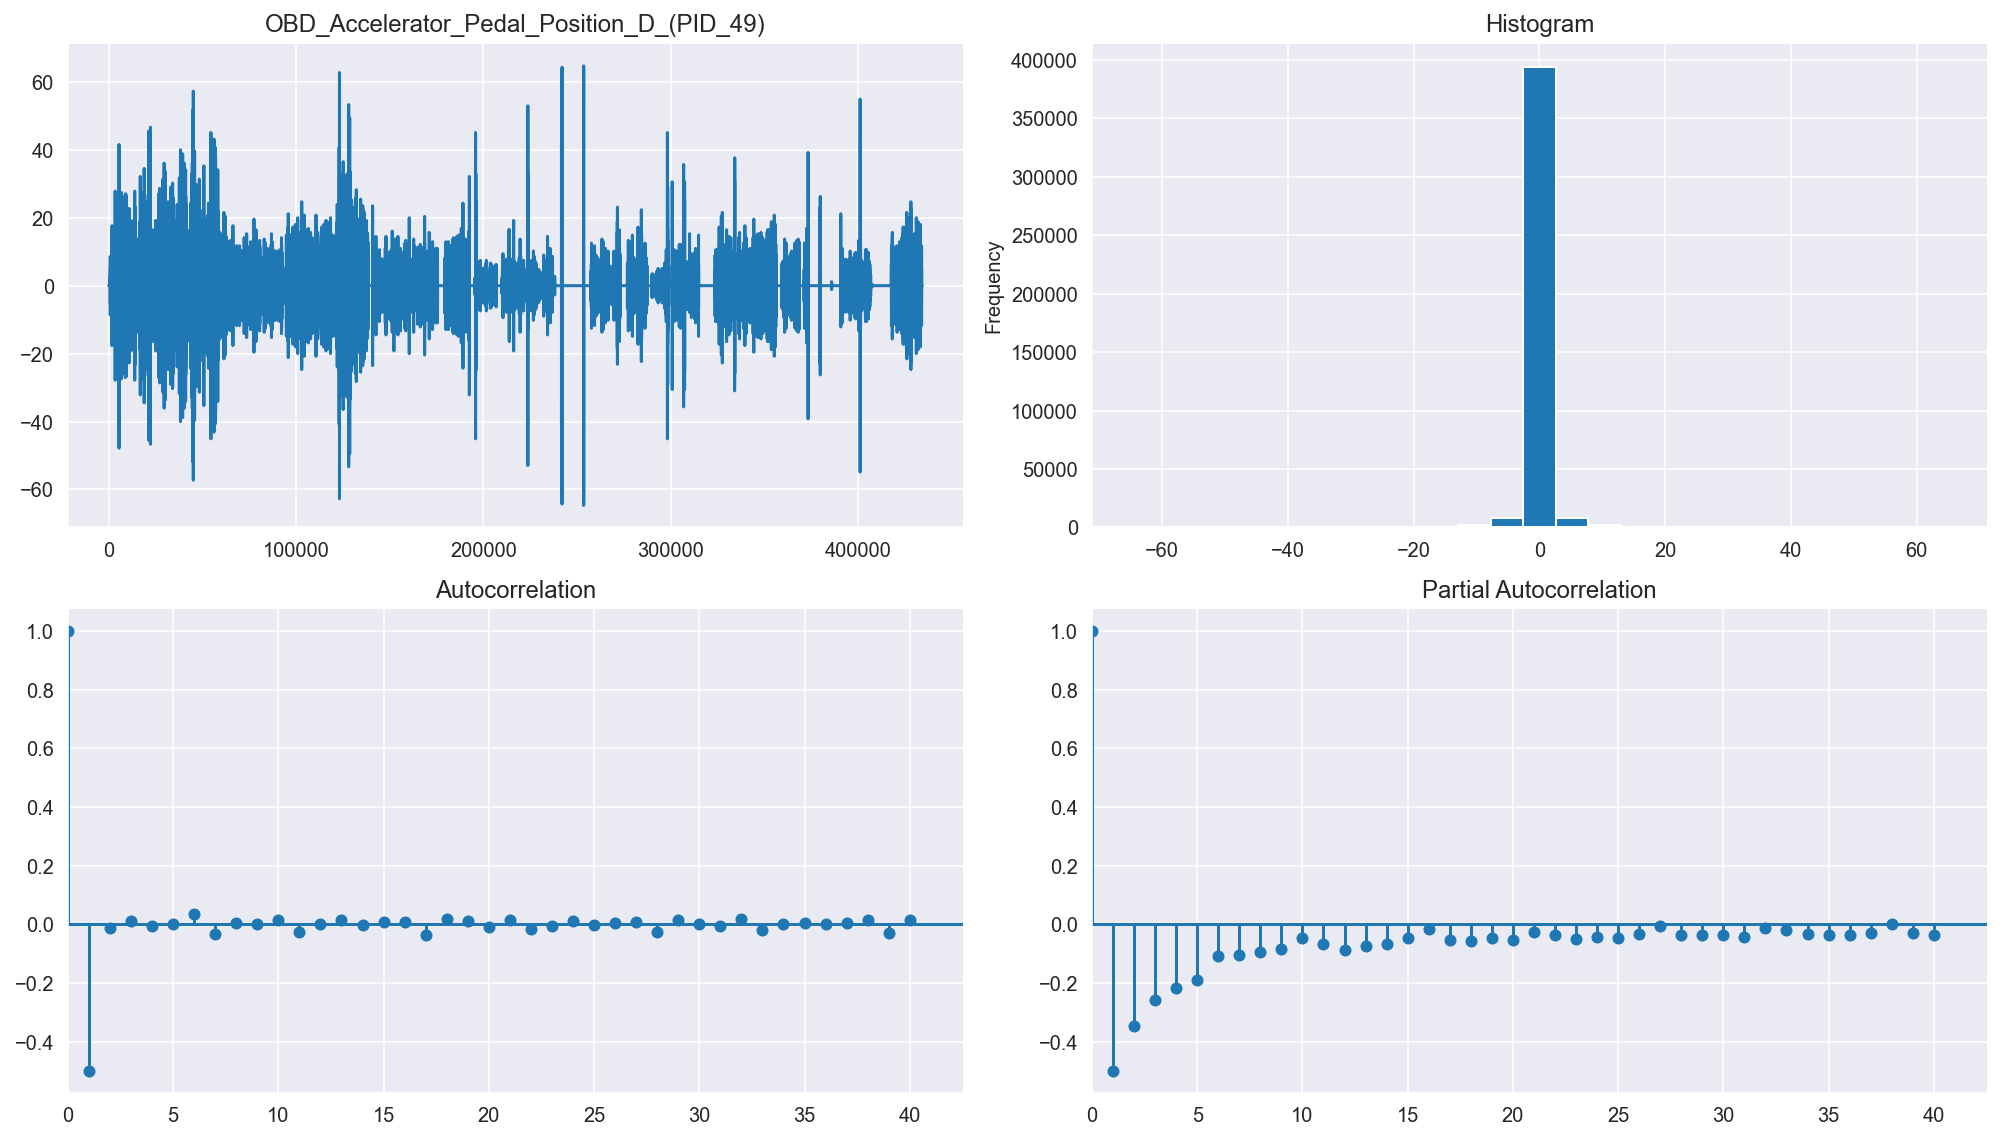

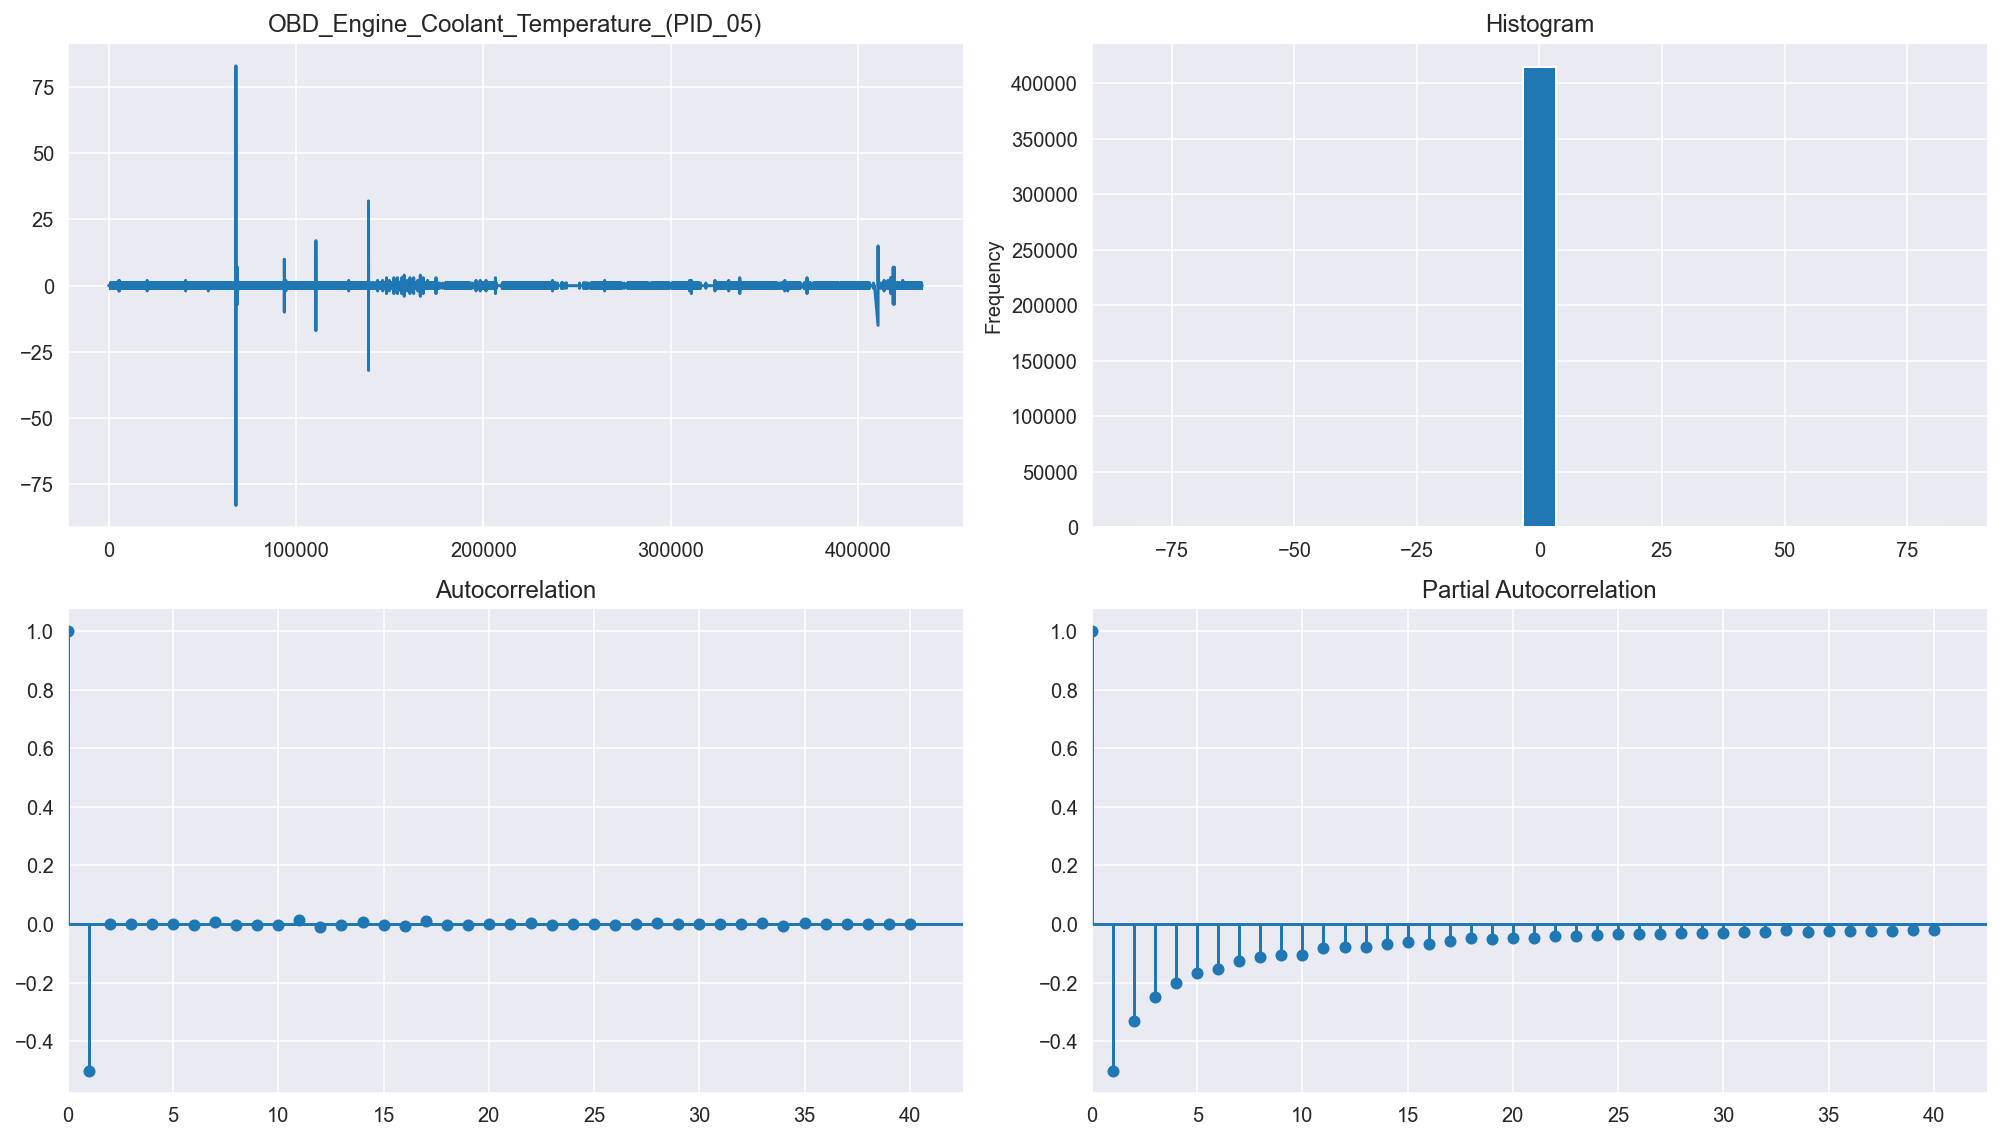

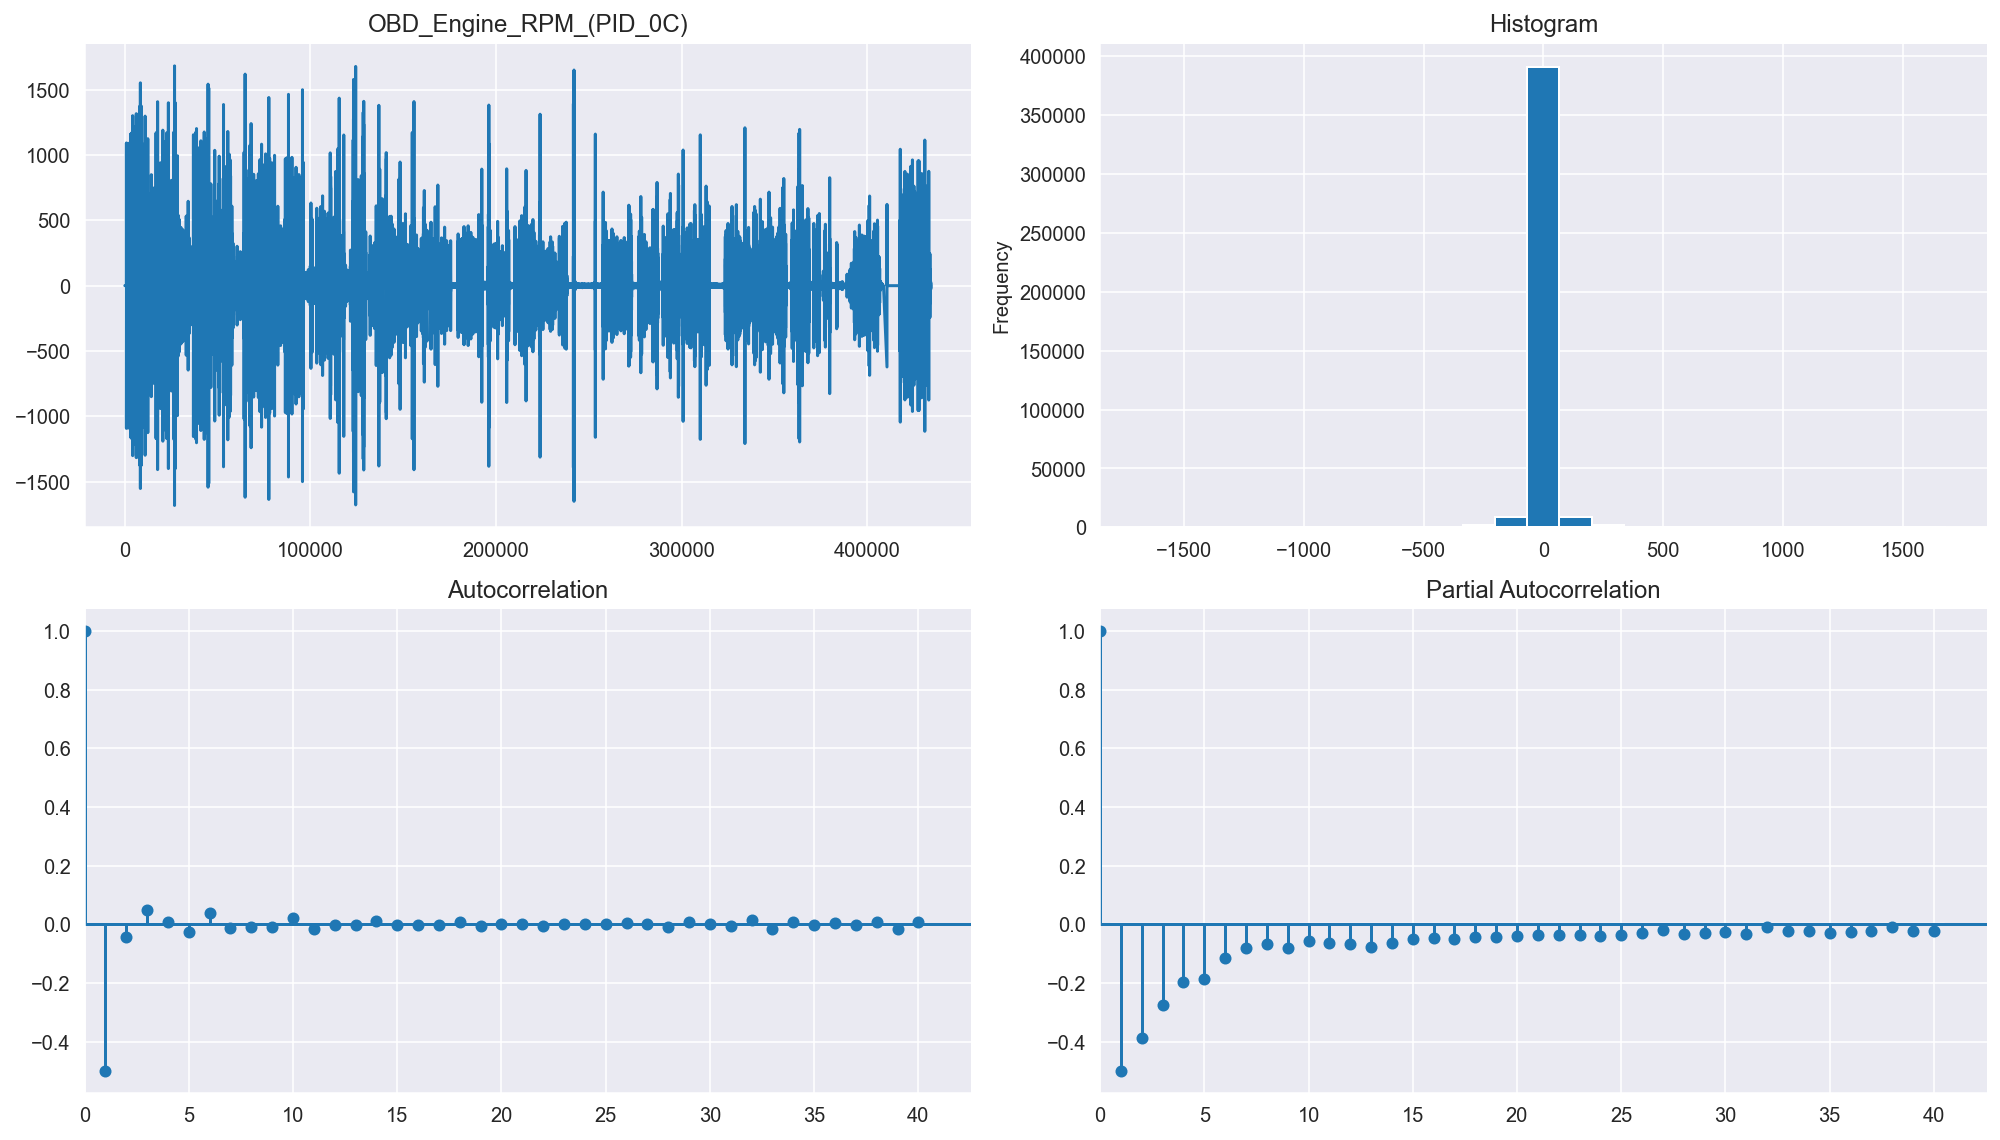

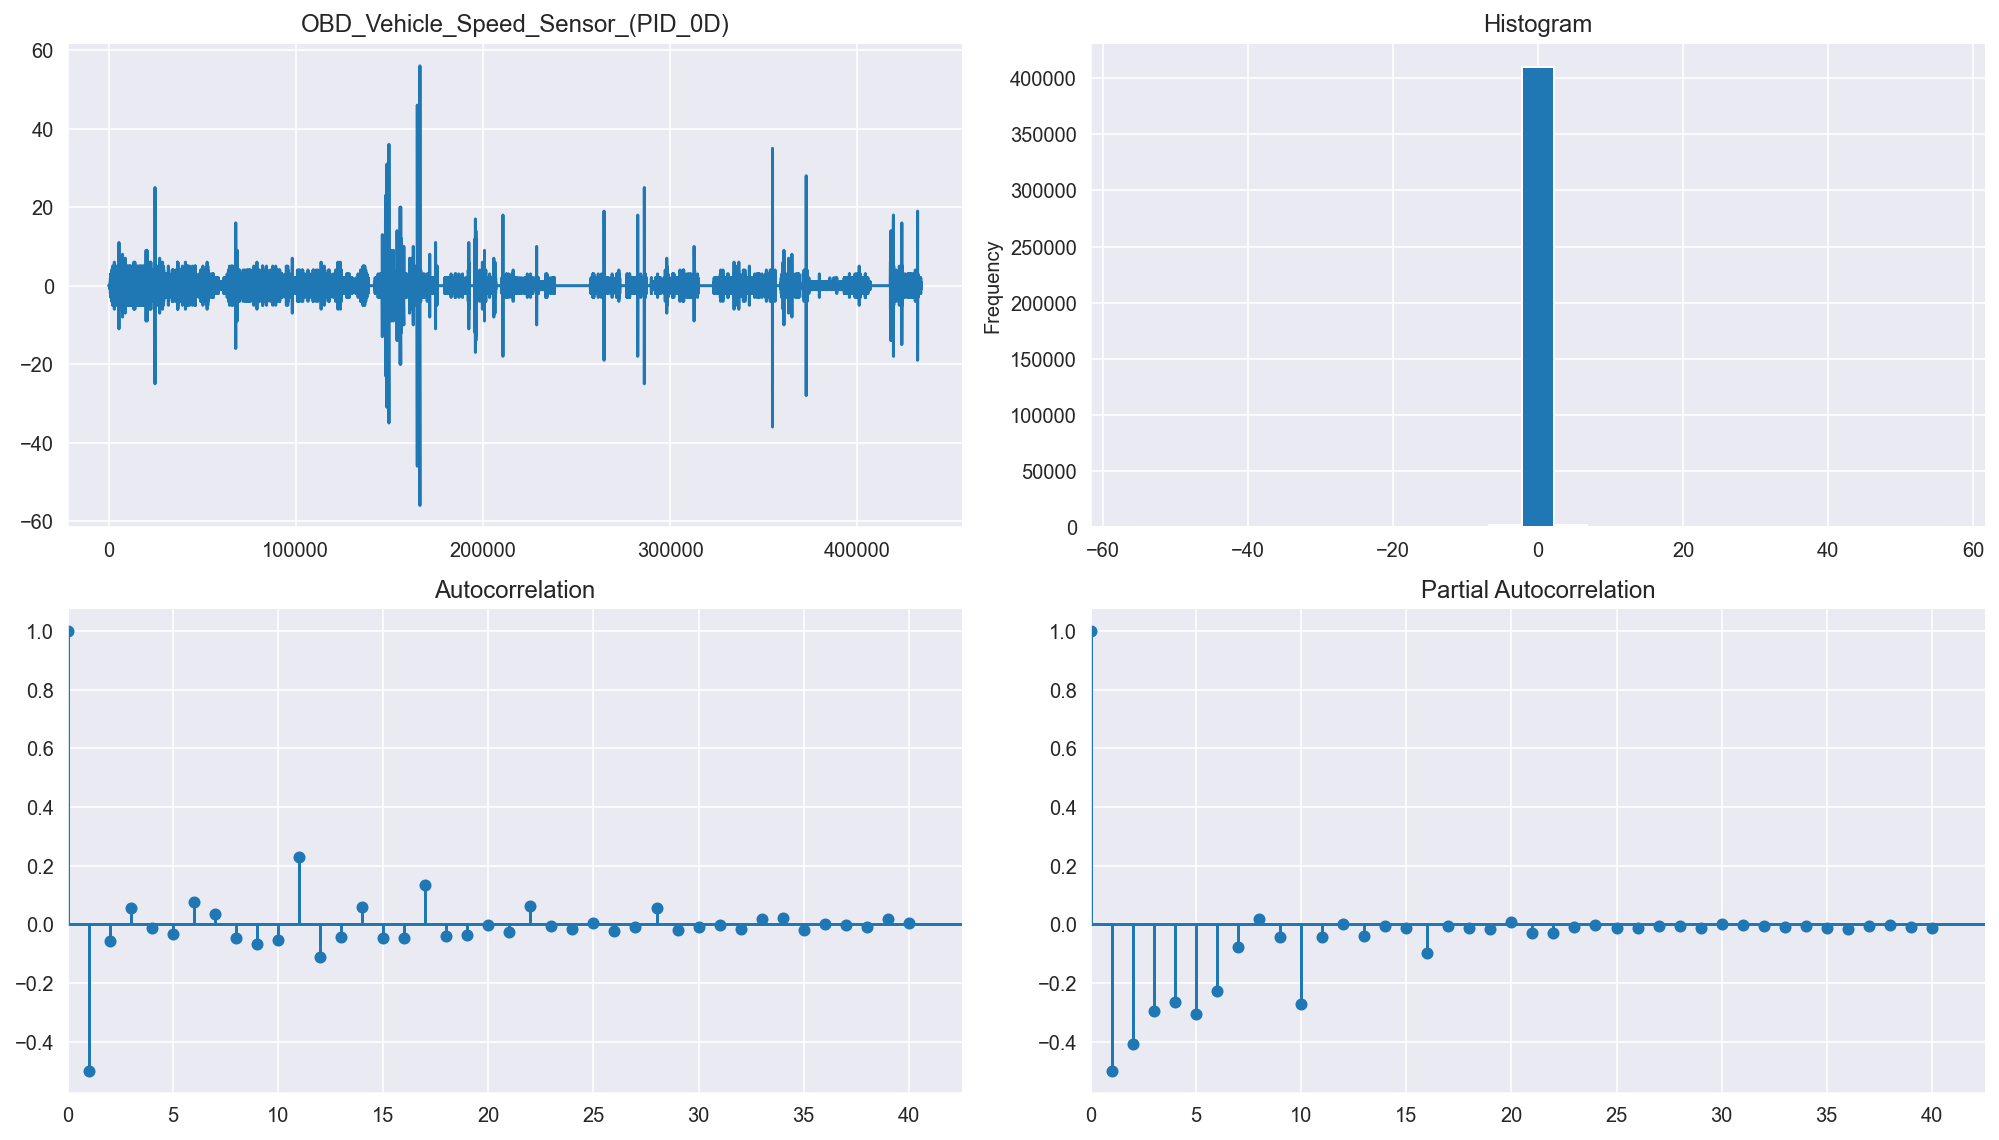

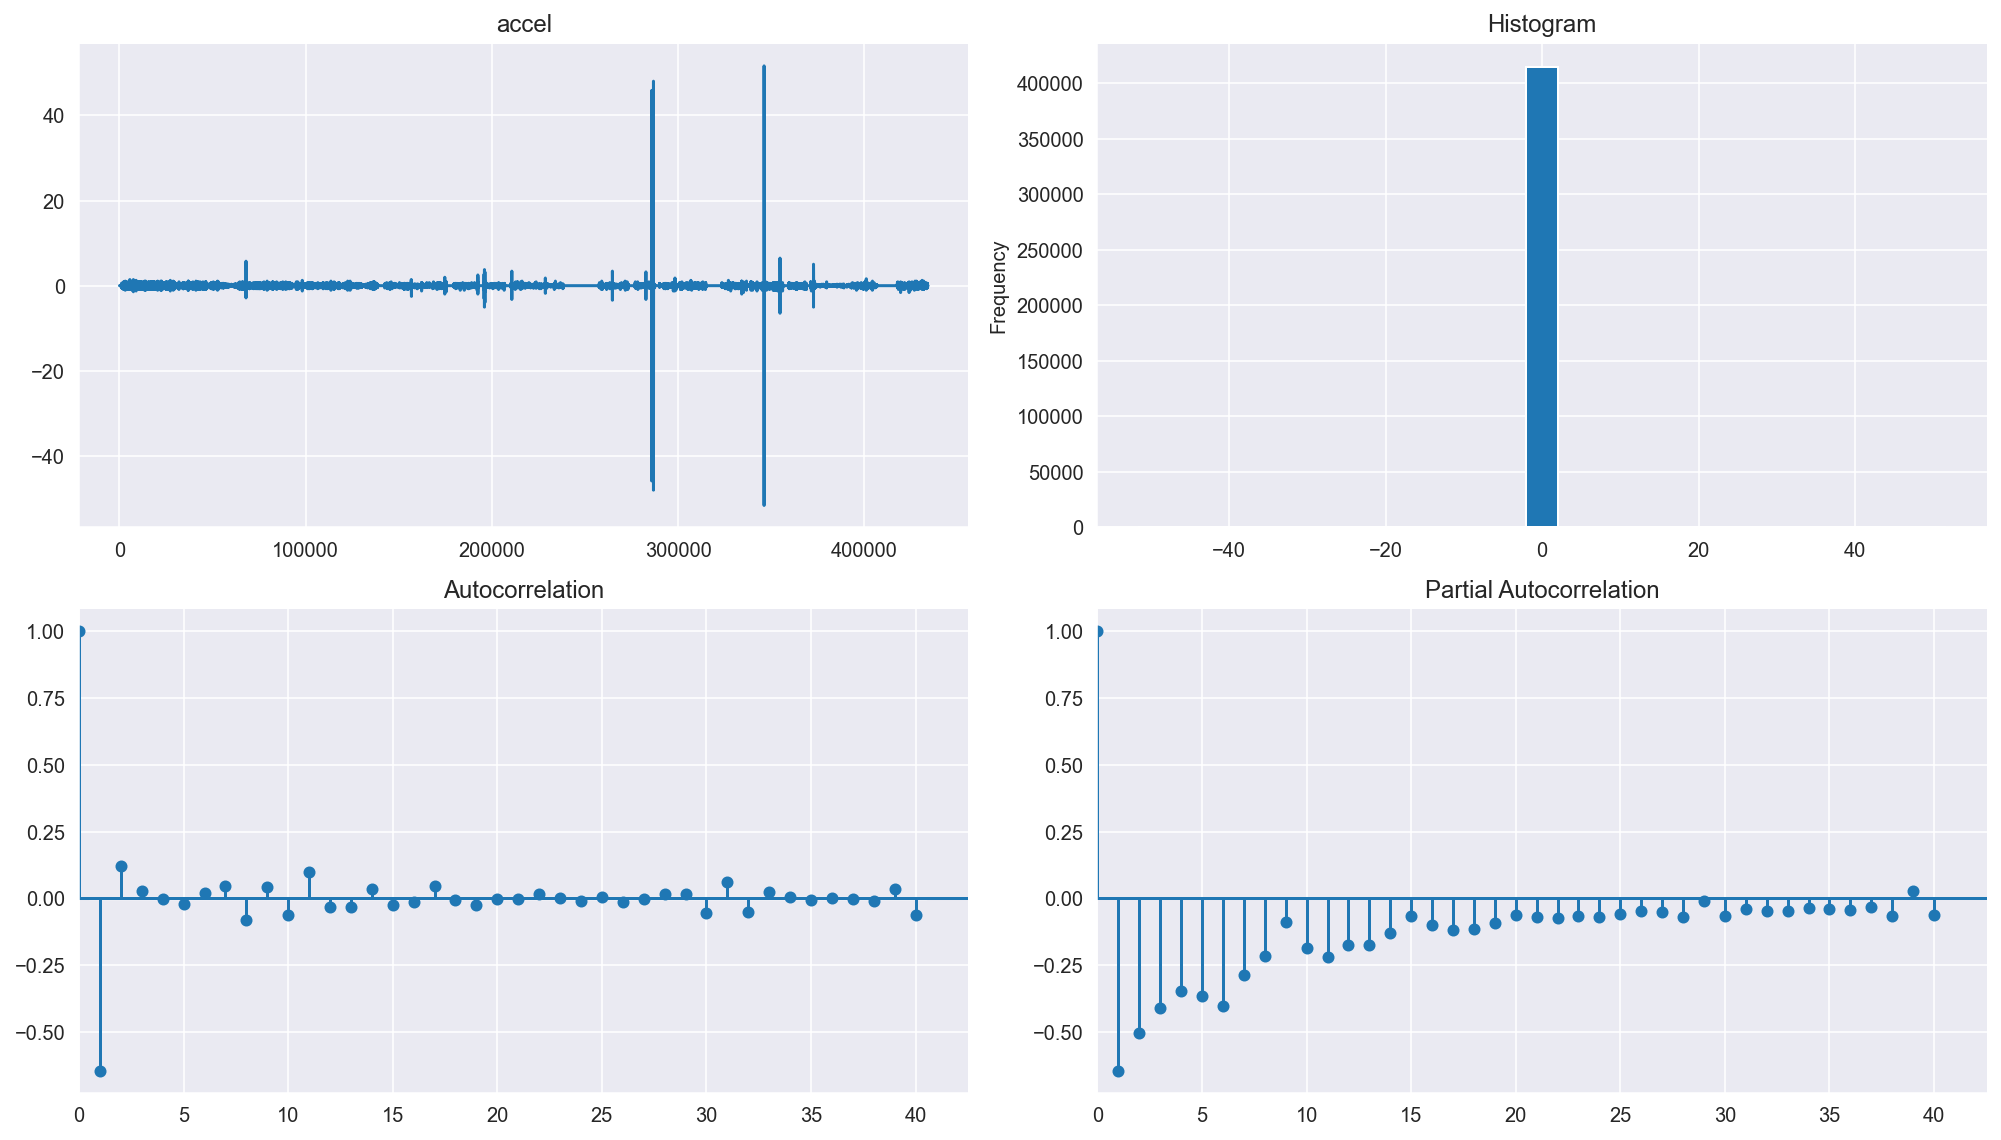

In [35]:
for name, column in df_diff2.iteritems():
    tsplot(column, name=column.name, lags=40)

## Vector Autoregression (VAR) model

In [19]:
model = VAR(df_diff2)
for i in range(5):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  -3.2422343615500835
BIC :  -3.2419707070138095
FPE :  0.03907648648521396
HQIC:  -3.242159139535329 

Lag Order = 1
AIC :  -7.570983103430223
BIC :  -7.568082897178226
FPE :  0.0005151857187220661
HQIC:  -7.57015565937182 

Lag Order = 2
AIC :  -9.44675421129508
BIC :  -9.441217441776423
FPE :  7.894538992580764e-05
HQIC:  -9.445174541745542 

Lag Order = 3
AIC :  -10.659644173883008
BIC :  -10.651470829546678
FPE :  2.347336523420779e-05
HQIC:  -10.65731227539483 

Lag Order = 4
AIC :  -11.887912527878065
BIC :  -11.877102597172964
FPE :  6.872981703776565e-06
HQIC:  -11.884828397003712 



In [20]:
result = model.fit(4)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Nov, 2020
Time:                     20:55:06
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -11.8771
Nobs:                     414761.    HQIC:                  -11.8848
Log likelihood:      -3.41947e+06    FPE:                6.87298e-06
AIC:                     -11.8879    Det(Omega_mle):     6.86619e-06
--------------------------------------------------------------------
Results for equation GPiS_NO
                                                  coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------
const                                                0.000000         0.006565            0.000           1.000
L1.GPiS_NO                                    

In [21]:
# model = sm.tsa.VARMAX(train, order=(5, 0))
# model_result = model.fit()
# model_result.plot_diagnostics()
# plt.show()

## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.
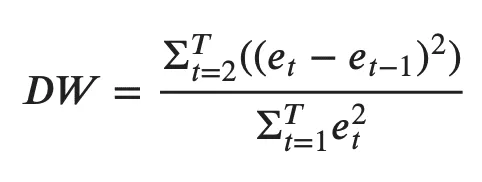

In [22]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(result.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

GPiS_NO : 2.01
AMB_Humidity : 2.08
AMB_Pressure : 2.18
AMB_Temperature : 2.16
EFM_ExhaustGasTemp : 2.11
OBD_Accelerator_Pedal_Position_D_(PID_49) : 2.08
OBD_Engine_Coolant_Temperature_(PID_05) : 2.07
OBD_Engine_RPM_(PID_0C) : 2.09
OBD_Vehicle_Speed_Sensor_(PID_0D) : 2.18
accel : 2.26


In [23]:
# Get the lag order
lag_order = result.k_ar
# Input data for forecasting
forecast_input = df_diff2.values[-lag_order:]

In [24]:
# Forecast
fc = result.forecast(y=forecast_input, steps=split)
df_forecast = pd.DataFrame(fc, index=df.index[-split:], columns=df.columns + '_2d')
df_forecast

,GPiS_NO_2d,AMB_Humidity_2d,AMB_Pressure_2d,AMB_Temperature_2d,EFM_ExhaustGasTemp_2d,OBD_Accelerator_Pedal_Position_D_(PID_49)_2d,OBD_Engine_Coolant_Temperature_(PID_05)_2d,OBD_Engine_RPM_(PID_0C)_2d,OBD_Vehicle_Speed_Sensor_(PID_0D)_2d,accel_2d
434171,4.590570e-03,-3.003015e-02,-4.685576e-02,-7.759427e-03,5.238203e-02,-1.347875e-02,-9.137700e-04,-1.738302,-9.051185e-04,1.604780e-03
434172,-1.111604e-02,9.538096e-03,1.395802e-01,9.704416e-03,3.517513e-02,1.546738e-02,2.580872e-04,0.007016,2.186698e-03,-3.982110e-03
434173,1.636861e-02,-2.099123e-03,-1.289970e-01,-2.847829e-03,-3.293951e-02,-1.294385e-03,8.617990e-05,0.991002,-4.074465e-03,4.215861e-03
434174,-1.626646e-02,-5.320667e-03,4.185083e-02,-1.542763e-03,3.738133e-02,-2.302198e-03,7.487707e-04,-0.031793,5.439132e-03,-2.243843e-03
434175,7.142786e-03,7.669994e-03,3.241497e-03,-3.998110e-04,-7.870423e-02,-3.347275e-03,-7.028056e-04,-0.312026,-3.912076e-03,9.568611e-04
...,...,...,...,...,...,...,...,...,...,...
480447,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10
480448,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10
480449,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10
480450,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10


In [25]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [26]:
df_results = invert_transformation(train, df_forecast, second_diff=True)        
df_results

,GPiS_NO_2d,AMB_Humidity_2d,AMB_Pressure_2d,AMB_Temperature_2d,EFM_ExhaustGasTemp_2d,OBD_Accelerator_Pedal_Position_D_(PID_49)_2d,OBD_Engine_Coolant_Temperature_(PID_05)_2d,OBD_Engine_RPM_(PID_0C)_2d,OBD_Vehicle_Speed_Sensor_(PID_0D)_2d,accel_2d,GPiS_NO_1d,GPiS_NO_forecast,AMB_Humidity_1d,AMB_Humidity_forecast,AMB_Pressure_1d,AMB_Pressure_forecast,AMB_Temperature_1d,AMB_Temperature_forecast,EFM_ExhaustGasTemp_1d,EFM_ExhaustGasTemp_forecast,OBD_Accelerator_Pedal_Position_D_(PID_49)_1d,OBD_Accelerator_Pedal_Position_D_(PID_49)_forecast,OBD_Engine_Coolant_Temperature_(PID_05)_1d,OBD_Engine_Coolant_Temperature_(PID_05)_forecast,OBD_Engine_RPM_(PID_0C)_1d,OBD_Engine_RPM_(PID_0C)_forecast,OBD_Vehicle_Speed_Sensor_(PID_0D)_1d,OBD_Vehicle_Speed_Sensor_(PID_0D)_forecast,accel_1d,accel_forecast
434171,4.590570e-03,-3.003015e-02,-4.685576e-02,-7.759427e-03,5.238203e-02,-1.347875e-02,-9.137700e-04,-1.738302,-9.051185e-04,1.604780e-03,0.016476,0.528716,-0.006191,39.117139,-0.046856,974.866646,-0.007759,-4.217126,-0.030618,46.886382,-0.013479,14.886322,-0.000914,95.999086,-1.738302,773.761698,-0.000905,-0.000905,0.001605,0.001605
434172,-1.111604e-02,9.538096e-03,1.395802e-01,9.704416e-03,3.517513e-02,1.546738e-02,2.580872e-04,0.007016,2.186698e-03,-3.982110e-03,0.005360,0.534075,0.003347,39.120487,0.092724,974.959370,0.001945,-4.215181,0.004557,46.890939,0.001989,14.888310,-0.000656,95.998431,-1.731286,772.030412,0.001282,0.000376,-0.002377,-0.000773
434173,1.636861e-02,-2.099123e-03,-1.289970e-01,-2.847829e-03,-3.293951e-02,-1.294385e-03,8.617990e-05,0.991002,-4.074465e-03,4.215861e-03,0.021728,0.555803,0.001248,39.121735,-0.036273,974.923098,-0.000903,-4.216084,-0.028383,46.862556,0.000694,14.889004,-0.000570,95.997861,-0.740284,771.290128,-0.002793,-0.002416,0.001839,0.001066
434174,-1.626646e-02,-5.320667e-03,4.185083e-02,-1.542763e-03,3.738133e-02,-2.302198e-03,7.487707e-04,-0.031793,5.439132e-03,-2.243843e-03,0.005462,0.561265,-0.004072,39.117663,0.005578,974.928676,-0.002446,-4.218530,0.008999,46.871555,-0.001608,14.887396,0.000179,95.998040,-0.772077,770.518051,0.002646,0.000230,-0.000405,0.000661
434175,7.142786e-03,7.669994e-03,3.241497e-03,-3.998110e-04,-7.870423e-02,-3.347275e-03,-7.028056e-04,-0.312026,-3.912076e-03,9.568611e-04,0.012604,0.573869,0.003598,39.121260,0.008820,974.937496,-0.002845,-4.221375,-0.069705,46.801849,-0.004955,14.882441,-0.000524,95.997517,-1.084103,769.433948,-0.001266,-0.001036,0.000552,0.001212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480447,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10,0.013304,589.650675,0.000591,61.745567,0.009507,1347.454086,-0.000677,-58.768877,-0.027819,-1147.516374,-0.002846,-105.971248,-0.000480,75.541644,-1.162249,-50177.784576,-0.000057,-4.338414,0.000153,6.153940
480448,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10,0.013304,589.663978,0.000591,61.746158,0.009507,1347.463594,-0.000677,-58.769555,-0.027819,-1147.544193,-0.002846,-105.974094,-0.000480,75.541164,-1.162251,-50178.946827,-0.000057,-4.338471,0.000153,6.154094
480449,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10,0.013304,589.677282,0.000591,61.746749,0.009507,1347.473101,-0.000677,-58.770232,-0.027819,-1147.572012,-0.002846,-105.976940,-0.000480,75.540684,-1.162254,-50180.109081,-0.000057,-4.338528,0.000153,6.154247
480450,2.251884e-08,4.346833e-09,6.173762e-08,2.198351e-08,-8.238180e-08,-9.678393e-09,-1.573651e-09,-0.000002,1.616194e-09,8.566086e-10,0.013304,589.690586,0.000591,61.747340,0.009507,1347.482608,-0.000677,-58.770910,-0.027819,-1147.599831,-0.002846,-105.979786,-0.000480,75.540204,-1.162256,-50181.271338,-0.000057,-4.338585,0.000153,6.154400


In [27]:
df_results.loc[:, ['GPiS_NO_forecast', 'AMB_Humidity_forecast', 'AMB_Pressure_forecast', 'AMB_Temperature_forecast',
       'EFM_ExhaustGasTemp_forecast', 'OBD_Accelerator_Pedal_Position_D_(PID_49)_forecast',
       'OBD_Engine_Coolant_Temperature_(PID_05)_forecast', 'OBD_Engine_RPM_(PID_0C)_forecast',
                   'OBD_Vehicle_Speed_Sensor_(PID_0D)_forecast', 'accel_forecast']]

,GPiS_NO_forecast,AMB_Humidity_forecast,AMB_Pressure_forecast,AMB_Temperature_forecast,EFM_ExhaustGasTemp_forecast,OBD_Accelerator_Pedal_Position_D_(PID_49)_forecast,OBD_Engine_Coolant_Temperature_(PID_05)_forecast,OBD_Engine_RPM_(PID_0C)_forecast,OBD_Vehicle_Speed_Sensor_(PID_0D)_forecast,accel_forecast
434171,0.528716,39.117139,974.866646,-4.217126,46.886382,14.886322,95.999086,773.761698,-0.000905,0.001605
434172,0.534075,39.120487,974.959370,-4.215181,46.890939,14.888310,95.998431,772.030412,0.000376,-0.000773
434173,0.555803,39.121735,974.923098,-4.216084,46.862556,14.889004,95.997861,771.290128,-0.002416,0.001066
434174,0.561265,39.117663,974.928676,-4.218530,46.871555,14.887396,95.998040,770.518051,0.000230,0.000661
434175,0.573869,39.121260,974.937496,-4.221375,46.801849,14.882441,95.997517,769.433948,-0.001036,0.001212
...,...,...,...,...,...,...,...,...,...,...
480447,589.650675,61.745567,1347.454086,-58.768877,-1147.516374,-105.971248,75.541644,-50177.784576,-4.338414,6.153940
480448,589.663978,61.746158,1347.463594,-58.769555,-1147.544193,-105.974094,75.541164,-50178.946827,-4.338471,6.154094
480449,589.677282,61.746749,1347.473101,-58.770232,-1147.572012,-105.976940,75.540684,-50180.109081,-4.338528,6.154247
480450,589.690586,61.747340,1347.482608,-58.770910,-1147.599831,-105.979786,75.540204,-50181.271338,-4.338585,6.154400


<AxesSubplot:>

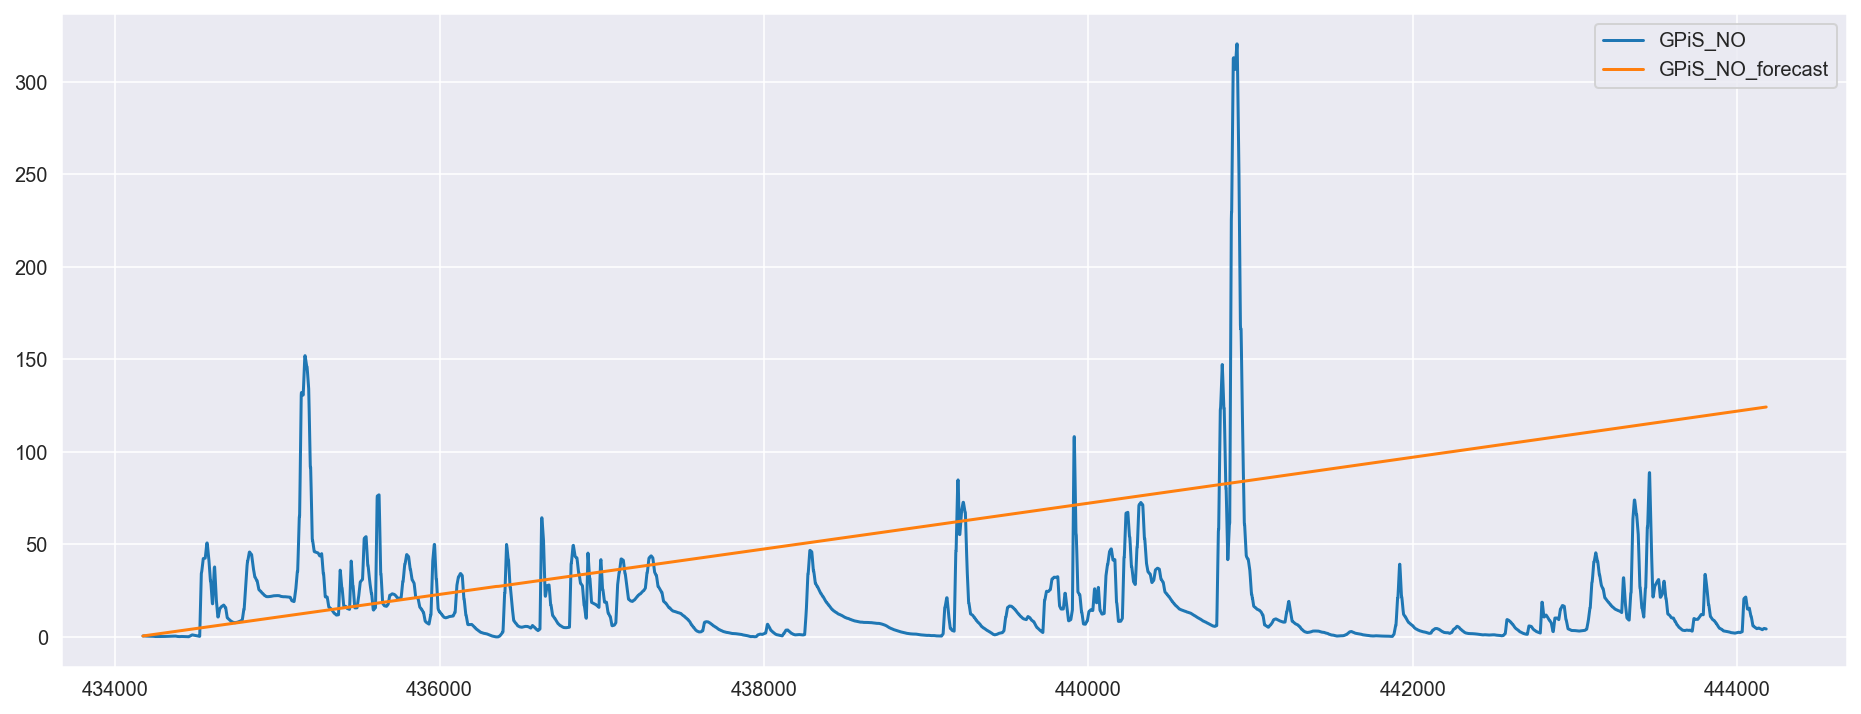

In [31]:
pd.concat([test['GPiS_NO'][:10000],df_results['GPiS_NO_forecast'][:10000]], axis=1).plot()

In [29]:
# pd.concat([test['GPiS_NO'],df_results['GPiS_NO_forecast']], axis=1).plot()

In [30]:
print('RMSE using VAR :' ,np.mean((test['GPiS_NO'] - df_results['GPiS_NO_forecast'])**2)**.5) # RMSE

RMSE using VAR : 300.78395351685793
